In [446]:
import warnings
warnings.filterwarnings('ignore')

from sigpyproc.readers import FilReader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import dates
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
from datetime import datetime, timedelta
import astropy.units as u
from astropy.time import Time
from astropy.visualization import ImageNormalize, PercentileInterval
from scipy.optimize import fsolve

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

# print(plt.get_backend())
path = '/home/mnedal/data/ilofar'

In [5]:
stokes = 'I'
filename = f'{path}/realta_ilofar_stokes{stokes}_20240514T1635.fil'

In [6]:
a = FilReader(filename) # header
header = a.header.to_dict()

In [7]:
[x for x in dir(a) if not x.startswith('_')]

['apply_channel_mask',
 'bandpass',
 'bitsinfo',
 'chan_stats',
 'chan_stride',
 'clean_rfi',
 'collapse',
 'compute_stats',
 'compute_stats_basic',
 'dedisperse',
 'downsample',
 'extract_bands',
 'extract_chans',
 'extract_samps',
 'filename',
 'fold',
 'header',
 'invert_freq',
 'logger',
 'read_block',
 'read_chan',
 'read_dedisp_block',
 'read_plan',
 'remove_zerodm',
 'requantize',
 'samp_stride',
 'subband']

In [8]:
header

{'filename': '/home/mnedal/data/ilofar/realta_ilofar_stokesI_20240514T1635.fil',
 'data_type': 'filterbank',
 'nchans': 488,
 'foff': -0.1953125,
 'fch1': 200.0,
 'nbits': 32,
 'tsamp': 0.00131072,
 'tstart': 60444.690972213044,
 'nsamples': 3433227,
 'nifs': 1,
 'coord': <SkyCoord (ICRS): (ra, dec) in deg
     (0., 0.)>,
 'azimuth': <Angle 235.90465428 deg>,
 'zenith': <Angle 133.53284027 deg>,
 'telescope': 'MeerKAT',
 'backend': 'FAKE',
 'source': 'Sun357',
 'frame': 'topocentric',
 'ibeam': 0,
 'nbeams': 0,
 'dm': 0,
 'period': 0,
 'accel': 0,
 'signed': False,
 'rawdatafile': 'unknown',
 'stream_info': {'entries': [{'filename': '/home/mnedal/data/ilofar/realta_ilofar_stokesI_20240514T1635.fil',
    'hdrlen': 347,
    'datalen': 6701659104,
    'nsamples': 3433227,
    'tstart': 60444.690972213044,
    'tsamp': 0.00131072}]},
 'basename': 'realta_ilofar_stokesI_20240514T1635',
 'extension': '.fil',
 'telescope_id': 64,
 'machine_id': 0,
 'bandwidth': 95.3125,
 'ftop': 200.09765625,

In [9]:
# filename = f'{path}/Sun357_20240514_stokesI.fil'
# a = FilReader(filename) # header
# header = a.header.to_dict()
# header

In [10]:
tstart_obs_str = Time(a.header.tstart, format='mjd').iso
n_samples = a.header.nsamples
print(tstart_obs_str, n_samples, sep='\n')

2024-05-14 16:34:59.999
3433227


In [11]:
data = a.read_block(start=0, nsamps=n_samples)

In [12]:
print(data.shape)

(488, 3433227)


In [13]:
# making time axis
tstart = Time(data.header.tstart, format='mjd')                    # tstart.iso will tell the time in format yyyy-mm-dd hh:mm:ss
tarray = tstart + (np.arange(data.shape[1])*data.header.tsamp*u.s) # making the time array for realta time resolution
print(len(tarray), tarray[0].iso, tarray[-1].iso, sep='\n')

3433227
2024-05-14 16:34:59.999
2024-05-14 17:49:59.997


In [14]:
dt = datetime.strptime(tarray[1].iso, '%Y-%m-%d %H:%M:%S.%f') - datetime.strptime(tarray[0].iso, '%Y-%m-%d %H:%M:%S.%f')
print('Time cadence:', dt.total_seconds()*1000, 'ms.')

Time cadence: 2.0 ms.


In [15]:
# Converting the array to datetime object
Tarray = [datetime.strptime(t.iso, '%Y-%m-%d %H:%M:%S.%f') for t in tarray]
print(Tarray[0], Tarray[-1], sep='\n')

2024-05-14 16:34:59.999000
2024-05-14 17:49:59.997000


In [16]:
# export the frequency axis
freqs = data.header.chan_freqs
print(freqs[0], freqs[-1], sep='\n')

200.0
104.8828125


In [17]:
def freq_axis(freqs):
    """
    Introduce gaps in the frequency axis of I-LOFAR REALTA data.
    """
    gap1 = np.flipud(freqs[288]+(np.arange(59)*0.390625))
    gap2 = np.flipud(freqs[88]+(np.arange(57)*0.390625))
    ax_shape = 59+57-1
    new_freq = np.zeros(ax_shape+freqs.shape[0])
    
    new_freq[0:88] = freqs[0:88]
    new_freq[88:145]  = gap2[:57]
    new_freq[145:345] = freqs[88:288]
    new_freq[345:404] = gap1[:59]
    new_freq[404:] = freqs[289:]
    
    return new_freq

In [18]:
new_freq = freq_axis(freqs)

data = np.log10(data)
data[np.where(np.isinf(data)==True)] = 0.0

data2 = np.empty((new_freq.shape[0], data.shape[1]))    
data2[:] = np.NaN
data2[0:88] = data[0:88]
data2[145:345] = data[88:288]
data2[404:] = data[289:]

In [19]:
freq_mode3 = np.linspace(10, 90, 199)
freq_mode5 = np.linspace(110, 190, 200)
freq_mode7 = np.linspace(210, 270, 88)

df_mode3 = pd.DataFrame(data=data2[404:].T, columns=freq_mode3[::-1])
df_mode5 = pd.DataFrame(data=data2[145:345].T, columns=freq_mode5[::-1])
df_mode7 = pd.DataFrame(data=data2[:88].T, columns=freq_mode7[::-1])

In [20]:
print(df_mode3.shape, df_mode5.shape, df_mode7.shape, sep='\n')

(3433227, 199)
(3433227, 200)
(3433227, 88)


In [21]:
# Ensure the 'time' column is in datetime format
df_mode3.index = pd.to_datetime(Tarray)
df_mode5.index = pd.to_datetime(Tarray)
df_mode7.index = pd.to_datetime(Tarray)

In [22]:
# Save the dataframes as a pickle files
df_mode3.to_pickle(f'{path}/df_mode3_realta_stokes{stokes}.pkl')
df_mode5.to_pickle(f'{path}/df_mode5_realta_stokes{stokes}.pkl')
df_mode7.to_pickle(f'{path}/df_mode7_realta_stokes{stokes}.pkl')

---

## Load the dataframes from the pickle files

In [447]:
stokes = 'I'

df_mode3 = pd.read_pickle(f'{path}/df_mode3_realta_stokes{stokes}.pkl')
df_mode5 = pd.read_pickle(f'{path}/df_mode5_realta_stokes{stokes}.pkl')
df_mode7 = pd.read_pickle(f'{path}/df_mode7_realta_stokes{stokes}.pkl')

time_mode3 = df_mode3.index
time_mode5 = df_mode5.index
time_mode7 = df_mode7.index

freq_mode3 = df_mode3.columns
freq_mode5 = df_mode5.columns
freq_mode7 = df_mode7.columns

In [448]:
df_mode3.head()

90.000000  89.595960  89.191919  88.787879  \
2024-05-14 16:34:59.999   1.799772   1.792704   1.819402   1.801856   
2024-05-14 16:35:00.001   1.798050   1.805530   1.841611   1.807242   
2024-05-14 16:35:00.002   1.802809   1.778404   1.805065   1.813894   
2024-05-14 16:35:00.003   1.796909   1.776495   1.787806   1.820709   
2024-05-14 16:35:00.004   1.828032   1.798176   1.811086   1.803947   

                         88.383838  87.979798  87.575758  87.171717  \
2024-05-14 16:34:59.999   1.821898   1.805349   1.839700   1.880792   
2024-05-14 16:35:00.001   1.801061   1.821736   1.827367   1.827421   
2024-05-14 16:35:00.002   1.830493   1.813557   1.822570   1.843120   
2024-05-14 16:35:00.003   1.827081   1.844028   1.833397   1.855872   
2024-05-14 16:35:00.004   1.828609   1.791825   1.842622   1.849136   

                         86.767677  86.363636  ...  13.636364  13.232323  \
2024-05-14 16:34:59.999   1.826038   1.846514  ...   3.568820   5.713190   
2024-05-14 16:35:00.001   1.821073   1.861757  ...   3.599643   5.800901   
2024-05-14 16:35:00.002   1.855594   1.867607  ...   3.567282   5.775797   
2024-05-14 16:35:00.003   1.843667   1.859612  ...   3.615343   5.741851   
2024-05-14 16:35:00.004   1.815879   1.884669  ...   3.612194   5.771443   

                         12.828283  12.424242  12.020202  11.616162  \
2024-05-14 16:34:59.999   3.028499   4.234807   3.177210   3.395557   
2024-05-14 16:35:00.001   2.970011   4.192112   3.187352   3.541002   
2024-05-14 16:35:00.002   2.957429   4.217224   3.177248   3.390445   
2024-05-14 16:35:00.003   3.075492   4.240929   3.199538   3.522466   
2024-05-14 16:35:00.004   3.025137   4.232731   3.159316   3.392504   

                         11.212121  10.808081  10.404040  10.000000  
2024-05-14 16:34:59.999   4.988539   2.805119   5.987510   4.049678  
2024-05-14 16:35:00.001   5.046845   2.820904   5.931093   3.924436  
2024-05-14 16:35:00.002   5.051265   2.815365   5.915247   3.795859  
2024-05-14 16:35:00.003   5.091839   2.799621   5.820334   3.902297  
2024-05-14 16:35:00.004   5.093588   2.789549   5.879279   3.775813  

[5 rows x 199 columns]

### Inspect the time and frequency resolution

In [479]:
dt = df_mode3.index[1] - df_mode3.index[0]
print(f'Time cadence: {dt.total_seconds()} s.')

df = df_mode3.columns[0] - df_mode3.columns[1]
print(f'Frequency cadence: {df:.3f} MHz.')

Time cadence: 0.002 s.
Frequency cadence: 0.404 MHz.


In [464]:
dt = df_mode5.index[1] - df_mode5.index[0]
print(f'Time cadence: {dt.total_seconds()} s.')

df = df_mode5.columns[0] - df_mode5.columns[1]
print(f'Frequency cadence: {df:.3f} MHz.')

Time cadence: 0.002 s.
Frequency cadence: 0.402 MHz.


In [465]:
dt = df_mode7.index[1] - df_mode7.index[0]
print(f'Time cadence: {dt.total_seconds()} s.')

df = df_mode7.columns[0] - df_mode7.columns[1]
print(f'Frequency cadence: {df:.3f} MHz.')

Time cadence: 0.002 s.
Frequency cadence: 0.690 MHz.


In [462]:
# dt = [df_mode3.index[i+1] - df_mode3.index[i] for i in range(len(df_mode3.index))]

In [478]:
i = 1000
df_mode3.index[i+1] - df_mode3.index[i]

Timedelta('0 days 00:00:00.001000')

In [474]:
i = 1000
df_mode7.index[i+1] - df_mode7.index[i]

Timedelta('0 days 00:00:00.001000')

In [468]:
i = 50
df_mode7.columns[i] - df_mode7.columns[i+1]

0.6896551724137794

In [480]:
# remove the const background
mode3_new = df_mode3.values - np.tile(np.nanmean(df_mode3.values,0), (df_mode3.values.shape[0],1))
mode5_new = df_mode5.values - np.tile(np.nanmean(df_mode5.values,0), (df_mode5.values.shape[0],1))
mode7_new = df_mode7.values - np.tile(np.nanmean(df_mode7.values,0), (df_mode7.values.shape[0],1))

In [481]:
# construct dataframes again
df_mode3_new = pd.DataFrame(data=mode3_new, columns=freq_mode3)
df_mode5_new = pd.DataFrame(data=mode5_new, columns=freq_mode5)
df_mode7_new = pd.DataFrame(data=mode7_new, columns=freq_mode7)

# set the time column as the dataframe index
df_mode3_new.index = pd.to_datetime(time_mode3)
df_mode5_new.index = pd.to_datetime(time_mode5)
df_mode7_new.index = pd.to_datetime(time_mode7)

In [482]:
df_mode3_new.head()

90.000000  89.595960  89.191919  88.787879  \
2024-05-14 16:34:59.999  -0.097223  -0.095804  -0.072854  -0.097929   
2024-05-14 16:35:00.001  -0.098944  -0.082978  -0.050645  -0.092543   
2024-05-14 16:35:00.002  -0.094185  -0.110103  -0.087191  -0.085891   
2024-05-14 16:35:00.003  -0.100085  -0.112013  -0.104450  -0.079076   
2024-05-14 16:35:00.004  -0.068962  -0.090332  -0.081170  -0.095837   

                         88.383838  87.979798  87.575758  87.171717  \
2024-05-14 16:34:59.999  -0.081905  -0.107719  -0.083374  -0.052462   
2024-05-14 16:35:00.001  -0.102741  -0.091332  -0.095708  -0.105833   
2024-05-14 16:35:00.002  -0.073310  -0.099511  -0.100505  -0.090134   
2024-05-14 16:35:00.003  -0.076721  -0.069039  -0.089678  -0.077382   
2024-05-14 16:35:00.004  -0.075194  -0.121243  -0.080453  -0.084118   

                         86.767677  86.363636  ...  13.636364  13.232323  \
2024-05-14 16:34:59.999  -0.119020  -0.112578  ...  -0.553649   0.457031   
2024-05-14 16:35:00.001  -0.123986  -0.097336  ...  -0.522826   0.544743   
2024-05-14 16:35:00.002  -0.089465  -0.091485  ...  -0.555188   0.519639   
2024-05-14 16:35:00.003  -0.101391  -0.099480  ...  -0.507127   0.485693   
2024-05-14 16:35:00.004  -0.129179  -0.074423  ...  -0.510276   0.515284   

                         12.828283  12.424242  12.020202  11.616162  \
2024-05-14 16:34:59.999  -0.085887   0.181764   0.007515  -0.710664   
2024-05-14 16:35:00.001  -0.144375   0.139068   0.017657  -0.565219   
2024-05-14 16:35:00.002  -0.156957   0.164180   0.007553  -0.715776   
2024-05-14 16:35:00.003  -0.038894   0.187885   0.029843  -0.583755   
2024-05-14 16:35:00.004  -0.089249   0.179687  -0.010379  -0.713717   

                         11.212121  10.808081  10.404040  10.000000  
2024-05-14 16:34:59.999   0.285406  -0.121056   1.157139   0.665124  
2024-05-14 16:35:00.001   0.343712  -0.105271   1.100722   0.539883  
2024-05-14 16:35:00.002   0.348132  -0.110810   1.084876   0.411305  
2024-05-14 16:35:00.003   0.388706  -0.126554   0.989963   0.517743  
2024-05-14 16:35:00.004   0.390455  -0.136626   1.048908   0.391259  

[5 rows x 199 columns]

In [483]:
# Slice the DataFrame between start_date and end_date
start_date = '2024-05-14 17:28:00'
# end_date   = '2024-05-14 17:00:00'

# df_mode3_slice = df_mode3.loc[start_date:end_date]
# df_mode5_slice = df_mode5.loc[start_date:end_date]
# df_mode7_slice = df_mode7.loc[start_date:end_date]

df_mode3_new = df_mode3_new.loc[start_date:]
df_mode5_new = df_mode5_new.loc[start_date:]
df_mode7_new = df_mode7_new.loc[start_date:]

In [484]:
del df_mode3
del df_mode5
del df_mode7

del mode3_new
del mode5_new
del mode7_new

### Plot the full dynamic spectrum

In [ ]:
min_range = -0.5
max_range = 2

fig = plt.figure(figsize=[12,7])
ax = fig.add_subplot(111)
ax.pcolormesh(df_mode3_new.index, df_mode3_new.columns, df_mode3_new.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(df_mode5_new.index, df_mode5_new.columns, df_mode5_new.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(df_mode7_new.index, df_mode7_new.columns, df_mode7_new.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

### Pick the type II bursts

In [486]:
typeII_1_mode3 = df_mode3_new.loc['2024-05-14 17:30:00':'2024-05-14 17:35:00']
typeII_1_mode5 = df_mode5_new.loc['2024-05-14 17:30:00':'2024-05-14 17:35:00']
typeII_1_mode7 = df_mode7_new.loc['2024-05-14 17:30:00':'2024-05-14 17:35:00']

typeII_2_mode3 = df_mode3_new.loc['2024-05-14 17:35:00':'2024-05-14 17:40:00']
typeII_2_mode5 = df_mode5_new.loc['2024-05-14 17:35:00':'2024-05-14 17:40:00']
typeII_2_mode7 = df_mode7_new.loc['2024-05-14 17:35:00':'2024-05-14 17:40:00']

typeII_3_mode3 = df_mode3_new.loc['2024-05-14 17:40:00':'2024-05-14 17:48:00']
typeII_3_mode5 = df_mode5_new.loc['2024-05-14 17:40:00':'2024-05-14 17:48:00']
typeII_3_mode7 = df_mode7_new.loc['2024-05-14 17:40:00':'2024-05-14 17:48:00']

In [487]:
del df_mode3_new
del df_mode5_new
del df_mode7_new

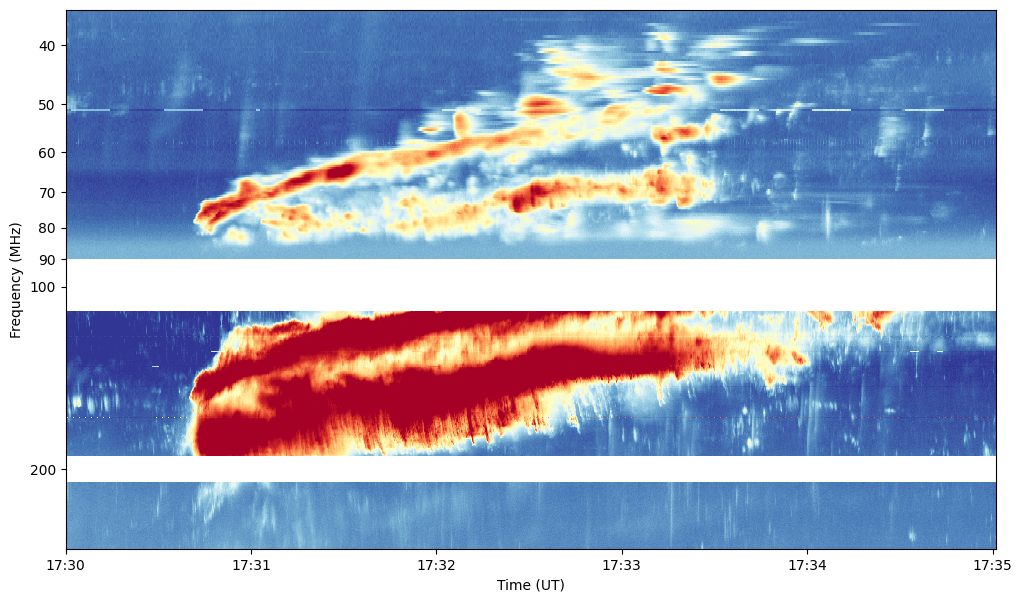

In [14]:
min_range = -0.5
max_range = 3

fig = plt.figure(figsize=[12,7])
ax = fig.add_subplot(111)
ax.pcolormesh(typeII_1_mode3.index, typeII_1_mode3.columns, typeII_1_mode3.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_1_mode5.index, typeII_1_mode5.columns, typeII_1_mode5.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_1_mode7.index, typeII_1_mode7.columns, typeII_1_mode7.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(max(ax.get_ylim()[::-1]), 35)
plt.show()

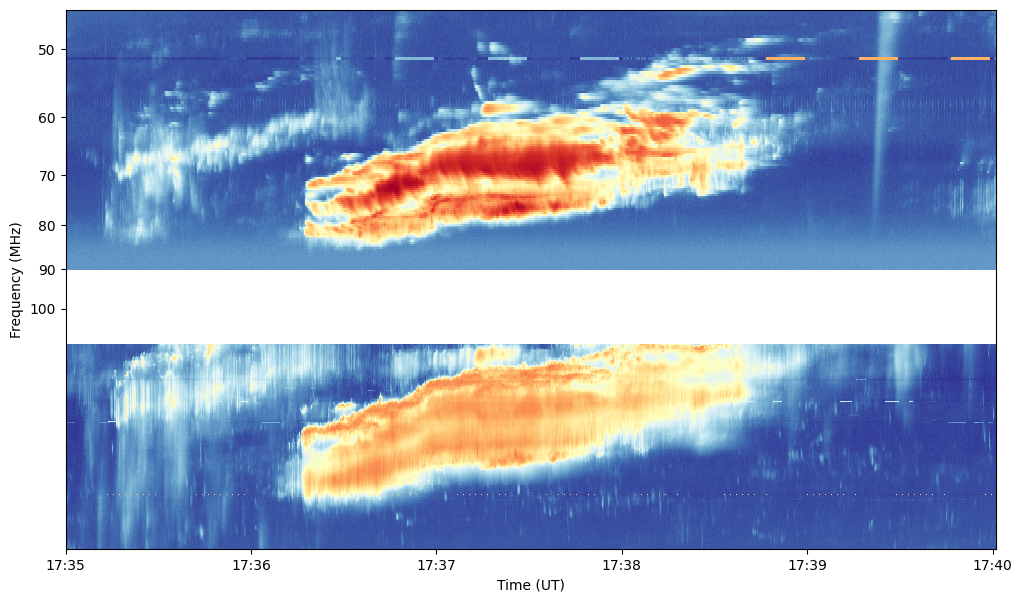

In [13]:
min_range = -0.5
max_range = 3

fig = plt.figure(figsize=[12,7])
ax = fig.add_subplot(111)
ax.pcolormesh(typeII_2_mode3.index, typeII_2_mode3.columns, typeII_2_mode3.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_2_mode5.index, typeII_2_mode5.columns, typeII_2_mode5.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_2_mode7.index, typeII_2_mode7.columns, typeII_2_mode7.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(190, 45)
plt.show()

In [ ]:
min_range = -0.5
max_range = 2

fig = plt.figure(figsize=[12,7])
ax = fig.add_subplot(111)
ax.pcolormesh(typeII_3_mode3.index, typeII_3_mode3.columns, typeII_3_mode3.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_3_mode5.index, typeII_3_mode5.columns, typeII_3_mode5.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_3_mode7.index, typeII_3_mode7.columns, typeII_3_mode7.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
# ax.xaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(90, 20)
plt.show()

## Clicking ...

In [15]:
import matplotlib
matplotlib.use('nbAgg')

## Applying Bezier curve method

In [557]:
time_cadence = abs(np.nanmedian(np.diff(combined_typeII_df1_1s.index)))
time_cadence.item()/

1.0

In [556]:
time_cadence

numpy.timedelta64(1000000000,'ns')

## Auto-tracing of type IIs

In [607]:
def draw_bezier(x1=0, y1=0, x2=0, y2=0, control=[0,0]):
    """
    Draw a Bezier curve using the given control points.
    The curve will be drawn from the point (x1, y1) to the point
    (x2, y2) using the control points (control[0], control[1]).
    """
    A = np.array([x2, y2])
    B = np.array(control)
    C = np.array([x1, y1])

    A = A.reshape(2,1)
    B = B.reshape(2,1)
    C = C.reshape(2,1)
    
    t = np.arange(0, 1, 0.02).reshape(1,-1)
    
    # length = len(df.index)
    # t = np.linspace(0, 1, length).reshape(1,-1)
    # t = np.arange(0, length, 1).reshape(1,-1)
    
    P0 = A * t + (1 - t) * B
    P1 = B * t + (1 - t) * C
    Pfinal = P0 * t + (1 - t) * P1

    return Pfinal

def extract_bezier_values(df, x1, y1, x2, y2, control):
    """
    Extract the values of a Bezier curve at the given control points.
    The curve will be drawn from the point (x1, y1) to the point
    (x2, y2) using the control points (control[0], control[1])
    """
    array = df.values.T
    Pfinal = draw_bezier(x1, y1, x2, y2, control)
    x_coords = np.round(Pfinal[0, :]).astype(int)
    y_coords = np.round(Pfinal[1, :]).astype(int)

    # Clip the coordinates to stay within array bounds
    x_coords = np.clip(x_coords, 0, array.shape[1] - 1)
    y_coords = np.clip(y_coords, 0, array.shape[0] - 1)

    # Extract values along the Bézier curve
    bezier_values = array[y_coords, x_coords]
    
    return bezier_values, x_coords, y_coords

In [497]:
# print(typeII_1_mode3_1s.columns[0], typeII_1_mode3_1s.columns[-1])
# print(typeII_1_mode5_1s.columns[0], typeII_1_mode5_1s.columns[-1])
# print(typeII_1_mode7_1s.columns[0], typeII_1_mode7_1s.columns[-1])

In [498]:
# print(typeII_1_mode3_1s.columns[1] - typeII_1_mode3_1s.columns[0])
# print(typeII_1_mode5_1s.columns[1] - typeII_1_mode5_1s.columns[0])
# print(typeII_1_mode7_1s.columns[1] - typeII_1_mode7_1s.columns[0])

In [489]:
def combine_ilofar_modes(mode3, mode5, mode7):
    """
    Combine data from the three observation modes of the I-LOFAR station into a single DataFrame.
    
    This function takes three pandas DataFrames,
    each representing an observation mode: Mode 3, Mode 5, and Mode 7.
    Each DataFrame contains frequency observations with datetime indices.
    The function combines these DataFrames into a single DataFrame,
    filling in frequency gaps between the modes with empty columns.

    Parameters:
    -----------
    mode3 : pandas.DataFrame
        DataFrame for Mode 3 observations, with datetime index and frequency columns.
    mode5 : pandas.DataFrame
        DataFrame for Mode 5 observations, with datetime index and frequency columns.
    mode7 : pandas.DataFrame
        DataFrame for Mode 7 observations, with datetime index and frequency columns.

    Returns:
    --------
    pandas.DataFrame
        A combined DataFrame containing all observations from Mode 3, Mode 5, and Mode 7, with empty columns
        filling the frequency gaps. The columns are sorted numerically.

    Notes:
    ------
    - The function calculates the frequency cadence for each mode by taking the absolute median difference 
      of the mode's column frequencies.
    - It then generates empty DataFrames to fill the frequency gaps between the observation modes.
    - Finally, it concatenates all DataFrames along the columns axis, converts the index to numerical dates, 
      and sorts the columns numerically.

    Example:
    --------
    >>> combined_df = combine_ilofar_modes(mode3_df, mode5_df, mode7_df)
    >>> print(combined_df.head())
    """
    mode3_freq_cadence = abs(np.nanmedian(np.diff(mode3.columns)))
    mode5_freq_cadence = abs(np.nanmedian(np.diff(mode5.columns)))
    mode7_freq_cadence = abs(np.nanmedian(np.diff(mode7.columns)))
    
    gap1_freqs = np.arange(90+mode3_freq_cadence, 110+mode3_freq_cadence, mode3_freq_cadence)
    df_gap1    = pd.DataFrame(index=mode3.index, columns=gap1_freqs)
    
    gap2_freqs = np.arange(190+mode5_freq_cadence, 210+mode5_freq_cadence, mode5_freq_cadence)
    df_gap2    = pd.DataFrame(index=mode3.index, columns=gap2_freqs)
    
    # Concatenate along columns axis
    combined_df       = pd.concat([mode3, df_gap1, mode5, df_gap2, mode7], axis=1)
    combined_df.index = mdates.date2num(combined_df.index)
    
    # Sort columns numerically
    combined_df = combined_df.reindex(sorted(combined_df.columns.astype('float')), axis=1).astype('float64')
    
    return combined_df

In [499]:
combined_typeII_df1 = combine_ilofar_modes(typeII_1_mode3, typeII_1_mode5, typeII_1_mode7)
combined_typeII_df2 = combine_ilofar_modes(typeII_2_mode3, typeII_2_mode5, typeII_2_mode7)
combined_typeII_df3 = combine_ilofar_modes(typeII_3_mode3, typeII_3_mode5, typeII_3_mode7)

In [501]:
combined_typeII_df1.shape, combined_typeII_df2.shape, combined_typeII_df3.shape

((229645, 587), (229645, 587), (366973, 587))

In [493]:
# mode3_freq_cadence = abs(np.nanmedian(np.diff(typeII_1_mode3_1s.columns)))
# mode5_freq_cadence = abs(np.nanmedian(np.diff(typeII_1_mode5_1s.columns)))
# mode7_freq_cadence = abs(np.nanmedian(np.diff(typeII_1_mode7_1s.columns)))

# print(mode3_freq_cadence)
# print(mode5_freq_cadence)
# print(mode7_freq_cadence)

In [494]:
# gap1_freqs = np.arange(90+mode3_freq_cadence, 110+mode3_freq_cadence, mode3_freq_cadence)
# df_gap1 = pd.DataFrame(index=typeII_1_mode3_1s.index, columns=gap1_freqs)

# gap2_freqs = np.arange(190+mode5_freq_cadence, 210+mode5_freq_cadence, mode5_freq_cadence)
# df_gap2 = pd.DataFrame(index=typeII_1_mode3_1s.index, columns=gap2_freqs)

In [495]:
# # Concatenate along columns axis
# combined_df = pd.concat([typeII_1_mode3_1s, df_gap1, typeII_1_mode5_1s, df_gap2, typeII_1_mode7_1s], axis=1)
# combined_df.index = mdates.date2num(combined_df.index)

# # Sort columns numerically
# combined_df = combined_df.reindex(sorted(combined_df.columns.astype('float')), axis=1).astype('float64')

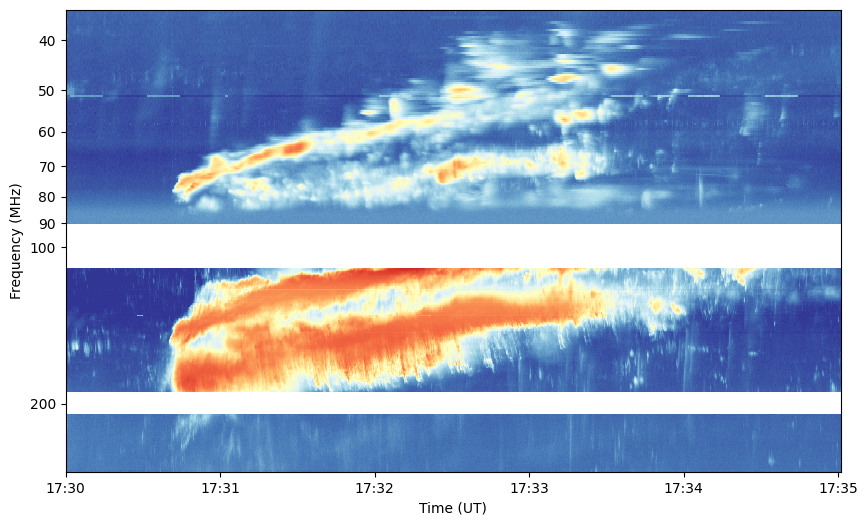

In [496]:
min_range = -0.5
max_range = 3

# Plot the spectrum
fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
ax.pcolormesh(combined_typeII_df1.index, combined_typeII_df1.columns, combined_typeII_df1.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(max(ax.get_ylim()[::-1]), 35)
plt.show()

In [506]:
# converts the float index to a DatetimeIndex
combined_typeII_df1.index = pd.to_datetime(combined_typeII_df1.index, origin='unix', unit='D')
combined_typeII_df2.index = pd.to_datetime(combined_typeII_df2.index, origin='unix', unit='D')
combined_typeII_df3.index = pd.to_datetime(combined_typeII_df3.index, origin='unix', unit='D')

# downsampling the data to 1-s resolution for faster testing and visualization
combined_typeII_df1_1s = combined_typeII_df1.resample('1S').mean()
combined_typeII_df2_1s = combined_typeII_df2.resample('1S').mean()
combined_typeII_df3_1s = combined_typeII_df3.resample('1S').mean()

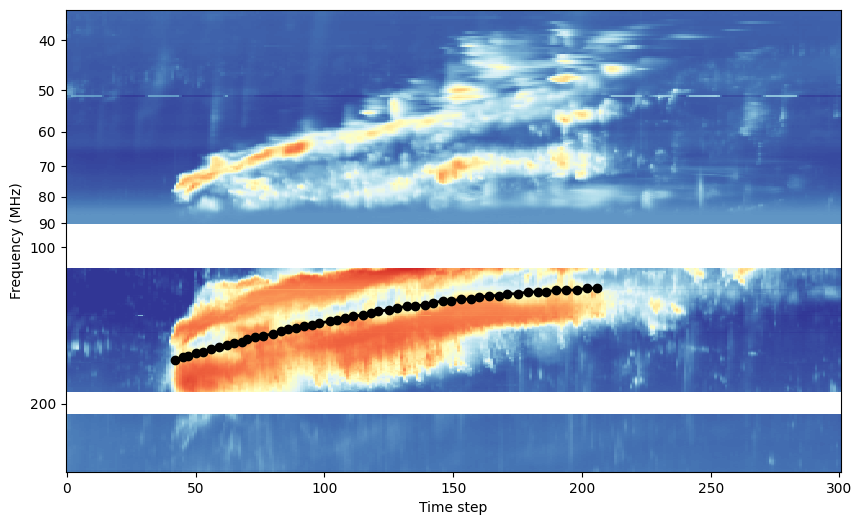

t_coords: [ 42  45  47  50  53  56  59  62  65  68  70  73  76  80  83  86  89  92
  95  98 102 105 108 111 115 118 121 125 128 132 135 139 142 146 149 153
 157 160 164 168 171 175 179 183 186 190 194 198 202 206]

f_coords: [165 163 162 160 159 157 156 154 153 152 150 149 148 147 145 144 143 142
 141 140 139 138 137 136 135 134 133 132 131 130 130 129 128 127 127 126
 126 125 124 124 123 123 122 122 122 121 121 121 120 120]


In [608]:
psudo_time = np.arange(len(combined_typeII_df1_1s.index))

# Define start and end points and control point for the Bézier curve
x1, y1 = 42, 165
x2, y2 = 210, 120
control = [110, 125]

# Plot the spectrum and the Bezier curve
fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
ax.pcolormesh(psudo_time, combined_typeII_df1_1s.columns, combined_typeII_df1_1s.values.T,
              vmin=-0.5, vmax=3, cmap='RdYlBu_r')
ax.set_yscale('log')

# Extract values along the Bézier curve
bezier_values, x_coords, y_coords = extract_bezier_values(combined_typeII_df1_1s, x1, y1, x2, y2, control)
ax.plot(x_coords, y_coords, 'ko-', linewidth=2)

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.set_xlabel('Time step')
ax.set_ylabel('Frequency (MHz)')
ax.set_ylim(max(ax.get_ylim()[::-1]), 35)
plt.show()

# print(f'intensity values: {bezier_values}\n')
print(f't_coords: {x_coords}\n')
print(f'f_coords: {y_coords}')

In [605]:
def has_duplicates(lst):
    return len(lst) != len(set(lst))

has_duplicates(x_coords), has_duplicates(y_coords)

(False, True)

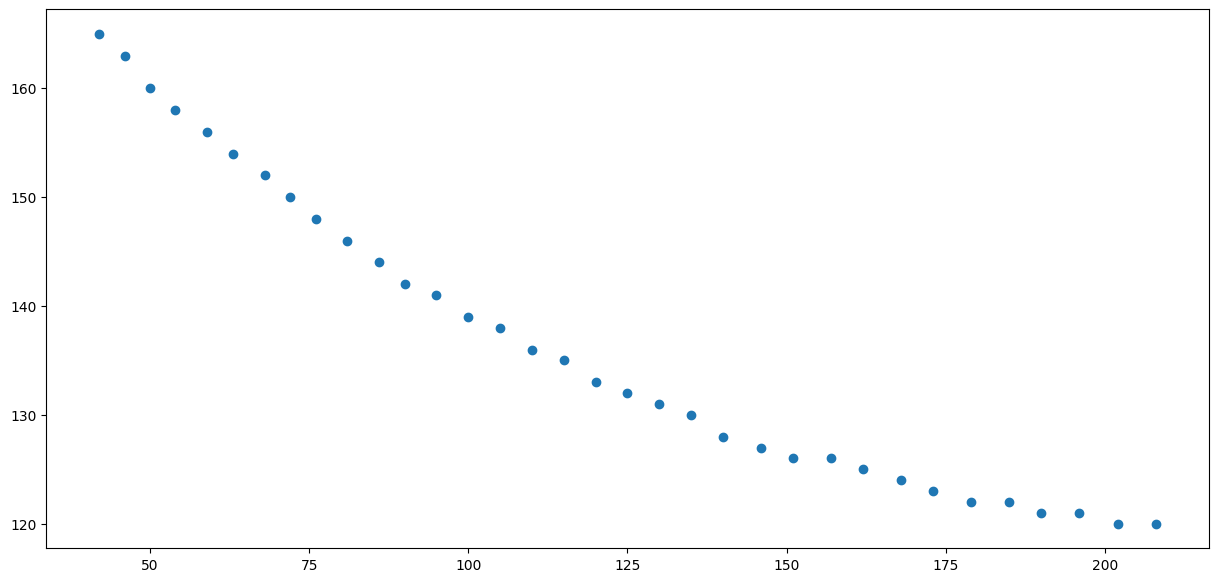

In [606]:
plt.figure(figsize=[15,7])
plt.scatter(x_coords, y_coords)

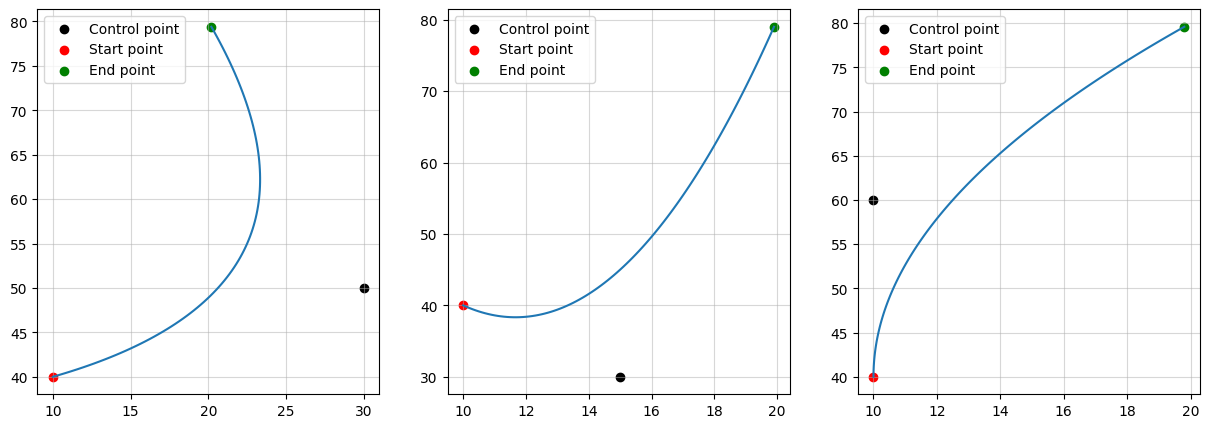

In [384]:
# Test draw Bezier curve
x1, y1 = 10, 40
x2, y2 = 20, 80

# Plot the Bezier curves with different control points
fig = plt.figure(figsize=[15,5])

ax = fig.add_subplot(131)
control_point = [30, 50]
Pfinal = draw_bezier(x1=x1, y1=y1, x2=x2, y2=y2, control=control_point)
x_coords = Pfinal[0,:]
y_coords = Pfinal[1,:]
ax.plot(x_coords, y_coords)
ax.scatter(control_point[0], control_point[1], c='k', label='Control point')
ax.scatter(x_coords[0], y_coords[0], c='r', label='Start point')
ax.scatter(x_coords[-1], y_coords[-1], c='g', label='End point')
ax.legend()
ax.grid(alpha=0.5)

ax = fig.add_subplot(132)
control_point = [15, 30]
Pfinal = draw_bezier(x1=x1, y1=y1, x2=x2, y2=y2, control=control_point)
x_coords = Pfinal[0,:]
y_coords = Pfinal[1,:]
ax.plot(x_coords, y_coords)
ax.scatter(control_point[0], control_point[1], c='k', label='Control point')
ax.scatter(x_coords[0], y_coords[0], c='r', label='Start point')
ax.scatter(x_coords[-1], y_coords[-1], c='g', label='End point')
ax.legend()
ax.grid(alpha=0.5)

ax = fig.add_subplot(133)
control_point = [10, 60]
Pfinal = draw_bezier(x1=x1, y1=y1, x2=x2, y2=y2, control=control_point)
x_coords = Pfinal[0,:]
y_coords = Pfinal[1,:]
ax.plot(x_coords, y_coords)
ax.scatter(control_point[0], control_point[1], c='k', label='Control point')
ax.scatter(x_coords[0], y_coords[0], c='r', label='Start point')
ax.scatter(x_coords[-1], y_coords[-1], c='g', label='End point')
ax.legend()
ax.grid(alpha=0.5)

plt.show()

In [385]:
Pfinal.shape

(2, 100)

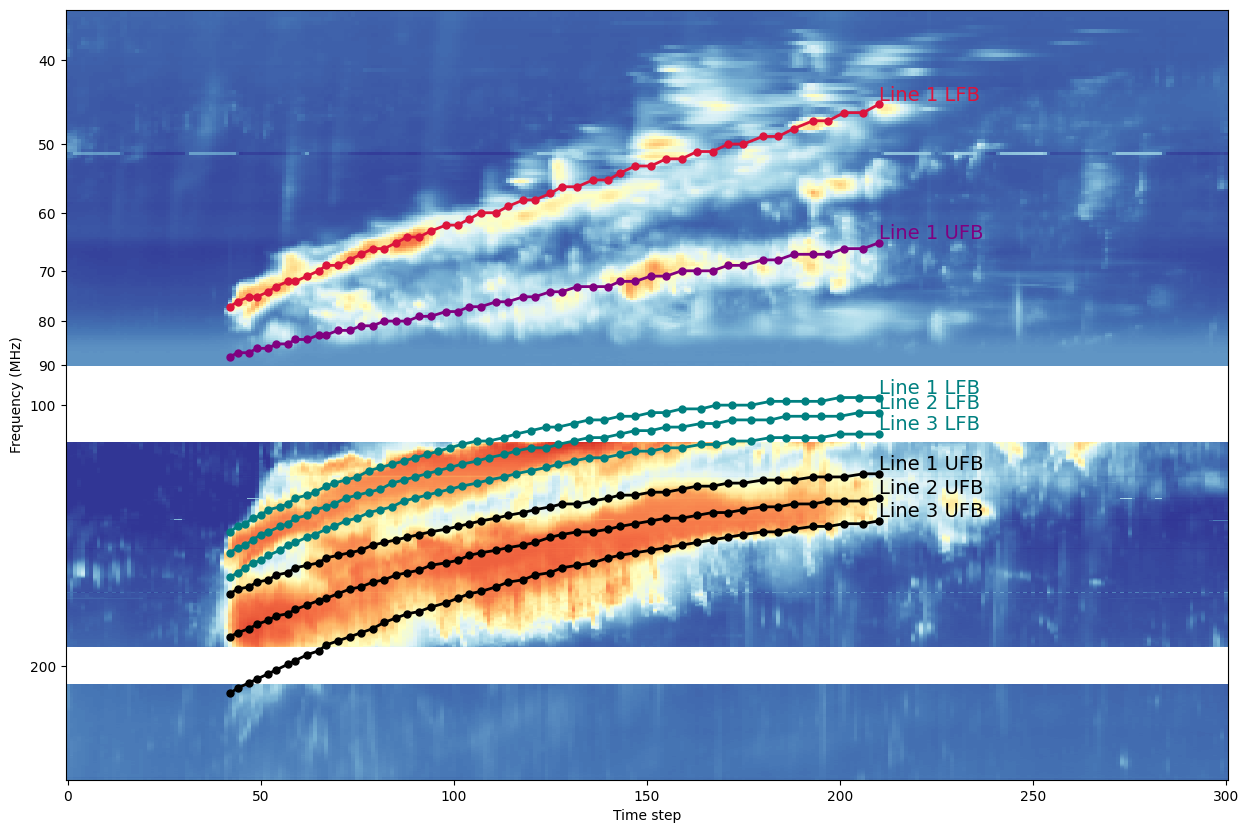

In [718]:
### Multiple bezier curves
psudo_time = np.arange(len(combined_typeII_df1_1s.index))

# Plot the spectrum and the Bezier curve
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)
ax.pcolormesh(psudo_time, combined_typeII_df1_1s.columns, combined_typeII_df1_1s.values.T,
              vmin=-0.5, vmax=3, cmap='RdYlBu_r')
ax.set_yscale('log')

## Extract values along the Bézier curve
curves_dict = {}

# Harmonic
bezier_values, x_coords, y_coords = extract_bezier_values(combined_typeII_df1_1s, 42, 140, 215, 98, [90, 100])
ax.plot(x_coords, y_coords, 'o-', c='teal', ms=5, lw=2)
ax.text(x_coords[-1], y_coords[-1], 'Line 1 LFB', color='teal', fontsize=14, verticalalignment='bottom', horizontalalignment='left')
curves_dict['time_h_lfb1'] = x_coords
curves_dict['freq_h_lfb1'] = y_coords
curves_dict['flux_h_lfb1'] = bezier_values

bezier_values, x_coords, y_coords = extract_bezier_values(combined_typeII_df1_1s, 42, 148, 215, 102, [90, 105])
ax.plot(x_coords, y_coords, 'o-', c='teal', ms=5, lw=2)
ax.text(x_coords[-1], y_coords[-1], 'Line 2 LFB', color='teal', fontsize=14, verticalalignment='bottom', horizontalalignment='left')
curves_dict['time_h_lfb2'] = x_coords
curves_dict['freq_h_lfb2'] = y_coords
curves_dict['flux_h_lfb2'] = bezier_values

bezier_values, x_coords, y_coords = extract_bezier_values(combined_typeII_df1_1s, 42, 158, 215, 108, [90, 110])
ax.plot(x_coords, y_coords, 'o-', c='teal', ms=5, lw=2)
ax.text(x_coords[-1], y_coords[-1], 'Line 3 LFB', color='teal', fontsize=14, verticalalignment='bottom', horizontalalignment='left')
curves_dict['time_h_lfb3'] = x_coords
curves_dict['freq_h_lfb3'] = y_coords
curves_dict['flux_h_lfb3'] = bezier_values


bezier_values, x_coords, y_coords = extract_bezier_values(combined_typeII_df1_1s, 42, 165, 215, 120, [100, 125])
ax.plot(x_coords, y_coords, 'o-', c='k', ms=5, lw=2)
ax.text(x_coords[-1], y_coords[-1], 'Line 1 UFB', fontsize=14, verticalalignment='bottom', horizontalalignment='left')
curves_dict['time_h_ufb1'] = x_coords
curves_dict['freq_h_ufb1'] = y_coords
curves_dict['flux_h_ufb1'] = bezier_values

bezier_values, x_coords, y_coords = extract_bezier_values(combined_typeII_df1_1s, 42, 185, 215, 128, [100, 135])
ax.plot(x_coords, y_coords, 'o-', c='black', ms=5, lw=2)
ax.text(x_coords[-1], y_coords[-1], 'Line 2 UFB', fontsize=14, verticalalignment='bottom', horizontalalignment='left')
curves_dict['time_h_ufb2'] = x_coords
curves_dict['freq_h_ufb2'] = y_coords
curves_dict['flux_h_ufb2'] = bezier_values

bezier_values, x_coords, y_coords = extract_bezier_values(combined_typeII_df1_1s, 42, 215, 215, 136, [100, 145])
ax.plot(x_coords, y_coords, 'o-', c='black', ms=5, lw=2)
ax.text(x_coords[-1], y_coords[-1], 'Line 3 UFB', fontsize=14, verticalalignment='bottom', horizontalalignment='left')
curves_dict['time_h_ufb3'] = x_coords
curves_dict['freq_h_ufb3'] = y_coords
curves_dict['flux_h_ufb3'] = bezier_values


# Fundamental
bezier_values, x_coords, y_coords = extract_bezier_values(combined_typeII_df1_1s, 42, 77, 215, 45, [100, 57])
ax.plot(x_coords, y_coords, 'o-', c='crimson', ms=5, lw=2)
ax.text(x_coords[-1], y_coords[-1], 'Line 1 LFB', color='crimson', fontsize=14, verticalalignment='bottom', horizontalalignment='left')
curves_dict['time_f_lfb3'] = x_coords
curves_dict['freq_f_lfb3'] = y_coords
curves_dict['flux_f_lfb3'] = bezier_values

bezier_values, x_coords, y_coords = extract_bezier_values(combined_typeII_df1_1s, 42, 88, 215, 65, [100, 75])
ax.plot(x_coords, y_coords, 'o-', c='purple', ms=5, lw=2)
ax.text(x_coords[-1], y_coords[-1], 'Line 1 UFB', color='purple', fontsize=14, verticalalignment='bottom', horizontalalignment='left')
curves_dict['time_f_ufb3'] = x_coords
curves_dict['freq_f_ufb3'] = y_coords
curves_dict['flux_f_ufb3'] = bezier_values

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.set_xlabel('Time step')
ax.set_ylabel('Frequency (MHz)')
ax.set_ylim(max(ax.get_ylim()[::-1]), 35)
plt.show()

In [713]:
curves_dict

{'time_h_lfb1': array([ 42,  44,  46,  48,  50,  52,  55,  57,  59,  62,  64,  67,  69,
         72,  75,  78,  81,  84,  87,  90,  93,  96,  99, 102, 106, 109,
        113, 116, 120, 124, 127, 131, 135, 139, 143, 147, 151, 155, 159,
        164, 168, 172, 177, 182, 186, 191, 195, 200, 205, 210]),
 'freq_h_lfb1': array([140, 138, 137, 135, 134, 132, 131, 130, 128, 127, 126, 124, 123,
        122, 121, 119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 110,
        109, 108, 107, 106, 106, 105, 104, 104, 103, 103, 102, 102, 101,
        101, 100, 100, 100,  99,  99,  99,  99,  98,  98,  98]),
 'flux_h_lfb1': array([-0.38317796, -0.39767305, -0.39193239, -0.37227569, -0.36428626,
        -0.34497453, -0.28861288, -0.21801897, -0.2996227 , -0.33031808,
        -0.3246664 , -0.34607004, -0.35803822, -0.36957375, -0.36993514,
        -0.35408717, -0.36977108, -0.34374926, -0.35678392, -0.34372133,
        -0.24101575, -0.29292419, -0.35368611, -0.34447017, -0.38081373,
        -0.07103839, -

In [719]:
# min_range = -0.5
# max_range = 3

# ## Define start and end points and control point for the Bézier curve

# # Given timestamp to find the nearest index
# given_timestamp_x1 = pd.Timestamp('2024-05-14 17:30:40')
# given_timestamp_x2 = pd.Timestamp('2024-05-14 17:33:30')

# # Find the nearest index
# nearest_index_x1 = typeII_1_mode3_1s.index.get_loc(given_timestamp_x1)
# nearest_index_x2 = typeII_1_mode3_1s.index.get_loc(given_timestamp_x2)

# x1 = mdates.date2num(typeII_1_mode3_1s.index[nearest_index_x1])
# x2 = mdates.date2num(typeII_1_mode3_1s.index[nearest_index_x2])

# # Given number to find the nearest index
# given_freq_y1 = 200
# given_freq_y2 = 120

# # Calculate differences
# differences1 = np.abs(typeII_1_mode3_1s.columns - given_freq_y1)
# differences2 = np.abs(typeII_1_mode3_1s.columns - given_freq_y2)

# # Find the nearest index
# nearest_index_y1 = differences1.argmin()
# nearest_index_y2 = differences2.argmin()

# y1 = typeII_1_mode3_1s.columns[nearest_index_y1]
# y2 = typeII_1_mode3_1s.columns[nearest_index_y2]

# control = [0, 1]

# # Extract values along the Bézier curve
# bezier_values, x_coords, y_coords = extract_bezier_values(typeII_1_mode5_1s.values.T, x1, y1, x2, y2, control)


# fig = plt.figure(figsize=[10,6])
# ax = fig.add_subplot(111)
# ax.pcolormesh(typeII_1_mode3_1s.index, typeII_1_mode3_1s.columns, typeII_1_mode3_1s.values.T,
#               vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
# ax.pcolormesh(typeII_1_mode5_1s.index, typeII_1_mode5_1s.columns, typeII_1_mode5_1s.values.T,
#               vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
# ax.pcolormesh(typeII_1_mode7_1s.index, typeII_1_mode7_1s.columns, typeII_1_mode7_1s.values.T,
#               vmin=min_range, vmax=max_range, cmap='RdYlBu_r')

# # plt.plot(x_coords, y_coords, 'ko--', linewidth=2)

# ax.set_yscale('log')

# # Define the custom ticks
# custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
# ax.set_yticks(custom_ticks)
# ax.set_yticklabels([str(tick) for tick in custom_ticks])
# ax.xaxis.set_minor_locator(AutoMinorLocator(n=6))
# ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# ax.set_ylim(max(ax.get_ylim()[::-1]), 35)
# plt.show()

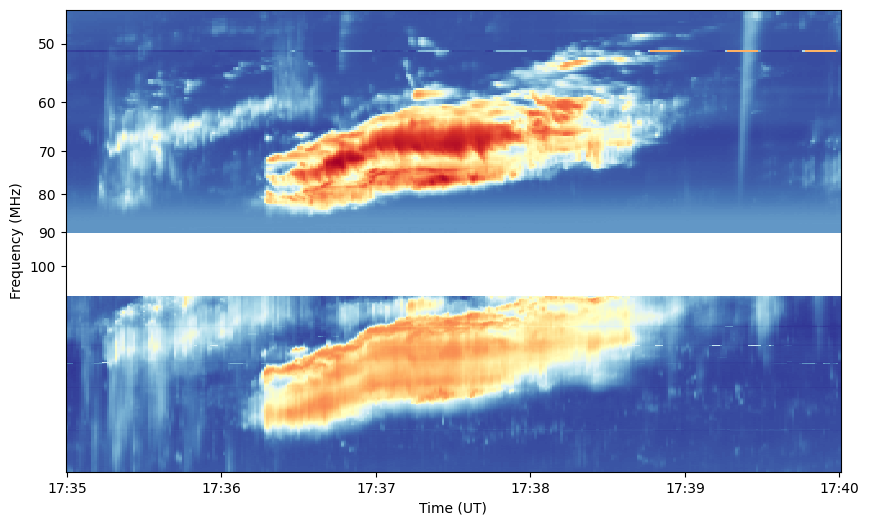

In [17]:
min_range = -0.5
max_range = 3

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
ax.pcolormesh(typeII_2_mode3_1s.index, typeII_2_mode3_1s.columns, typeII_2_mode3_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_2_mode5_1s.index, typeII_2_mode5_1s.columns, typeII_2_mode5_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_2_mode7_1s.index, typeII_2_mode7_1s.columns, typeII_2_mode7_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(190, 45)
plt.show()

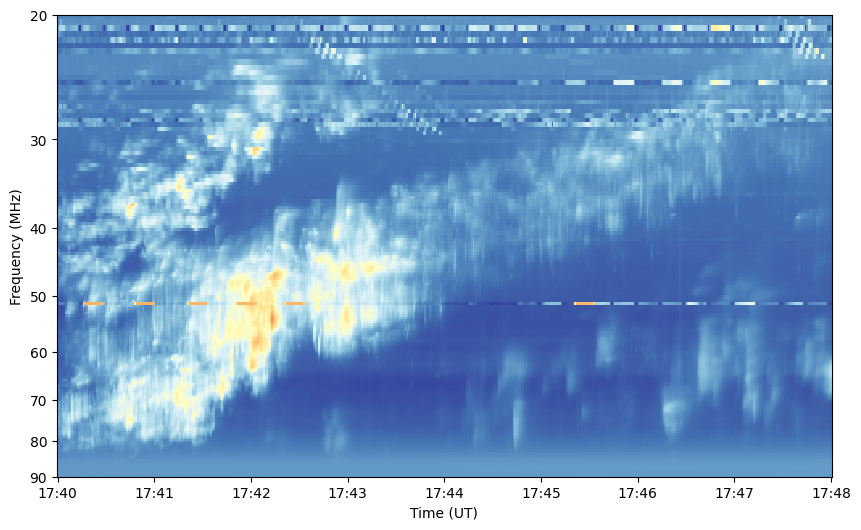

In [18]:
min_range = -0.5
max_range = 3

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
ax.pcolormesh(typeII_3_mode3_1s.index, typeII_3_mode3_1s.columns, typeII_3_mode3_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_3_mode5_1s.index, typeII_3_mode5_1s.columns, typeII_3_mode5_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_3_mode7_1s.index, typeII_3_mode7_1s.columns, typeII_3_mode7_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(90, 20)
plt.show()

<IPython.core.display.Javascript object>


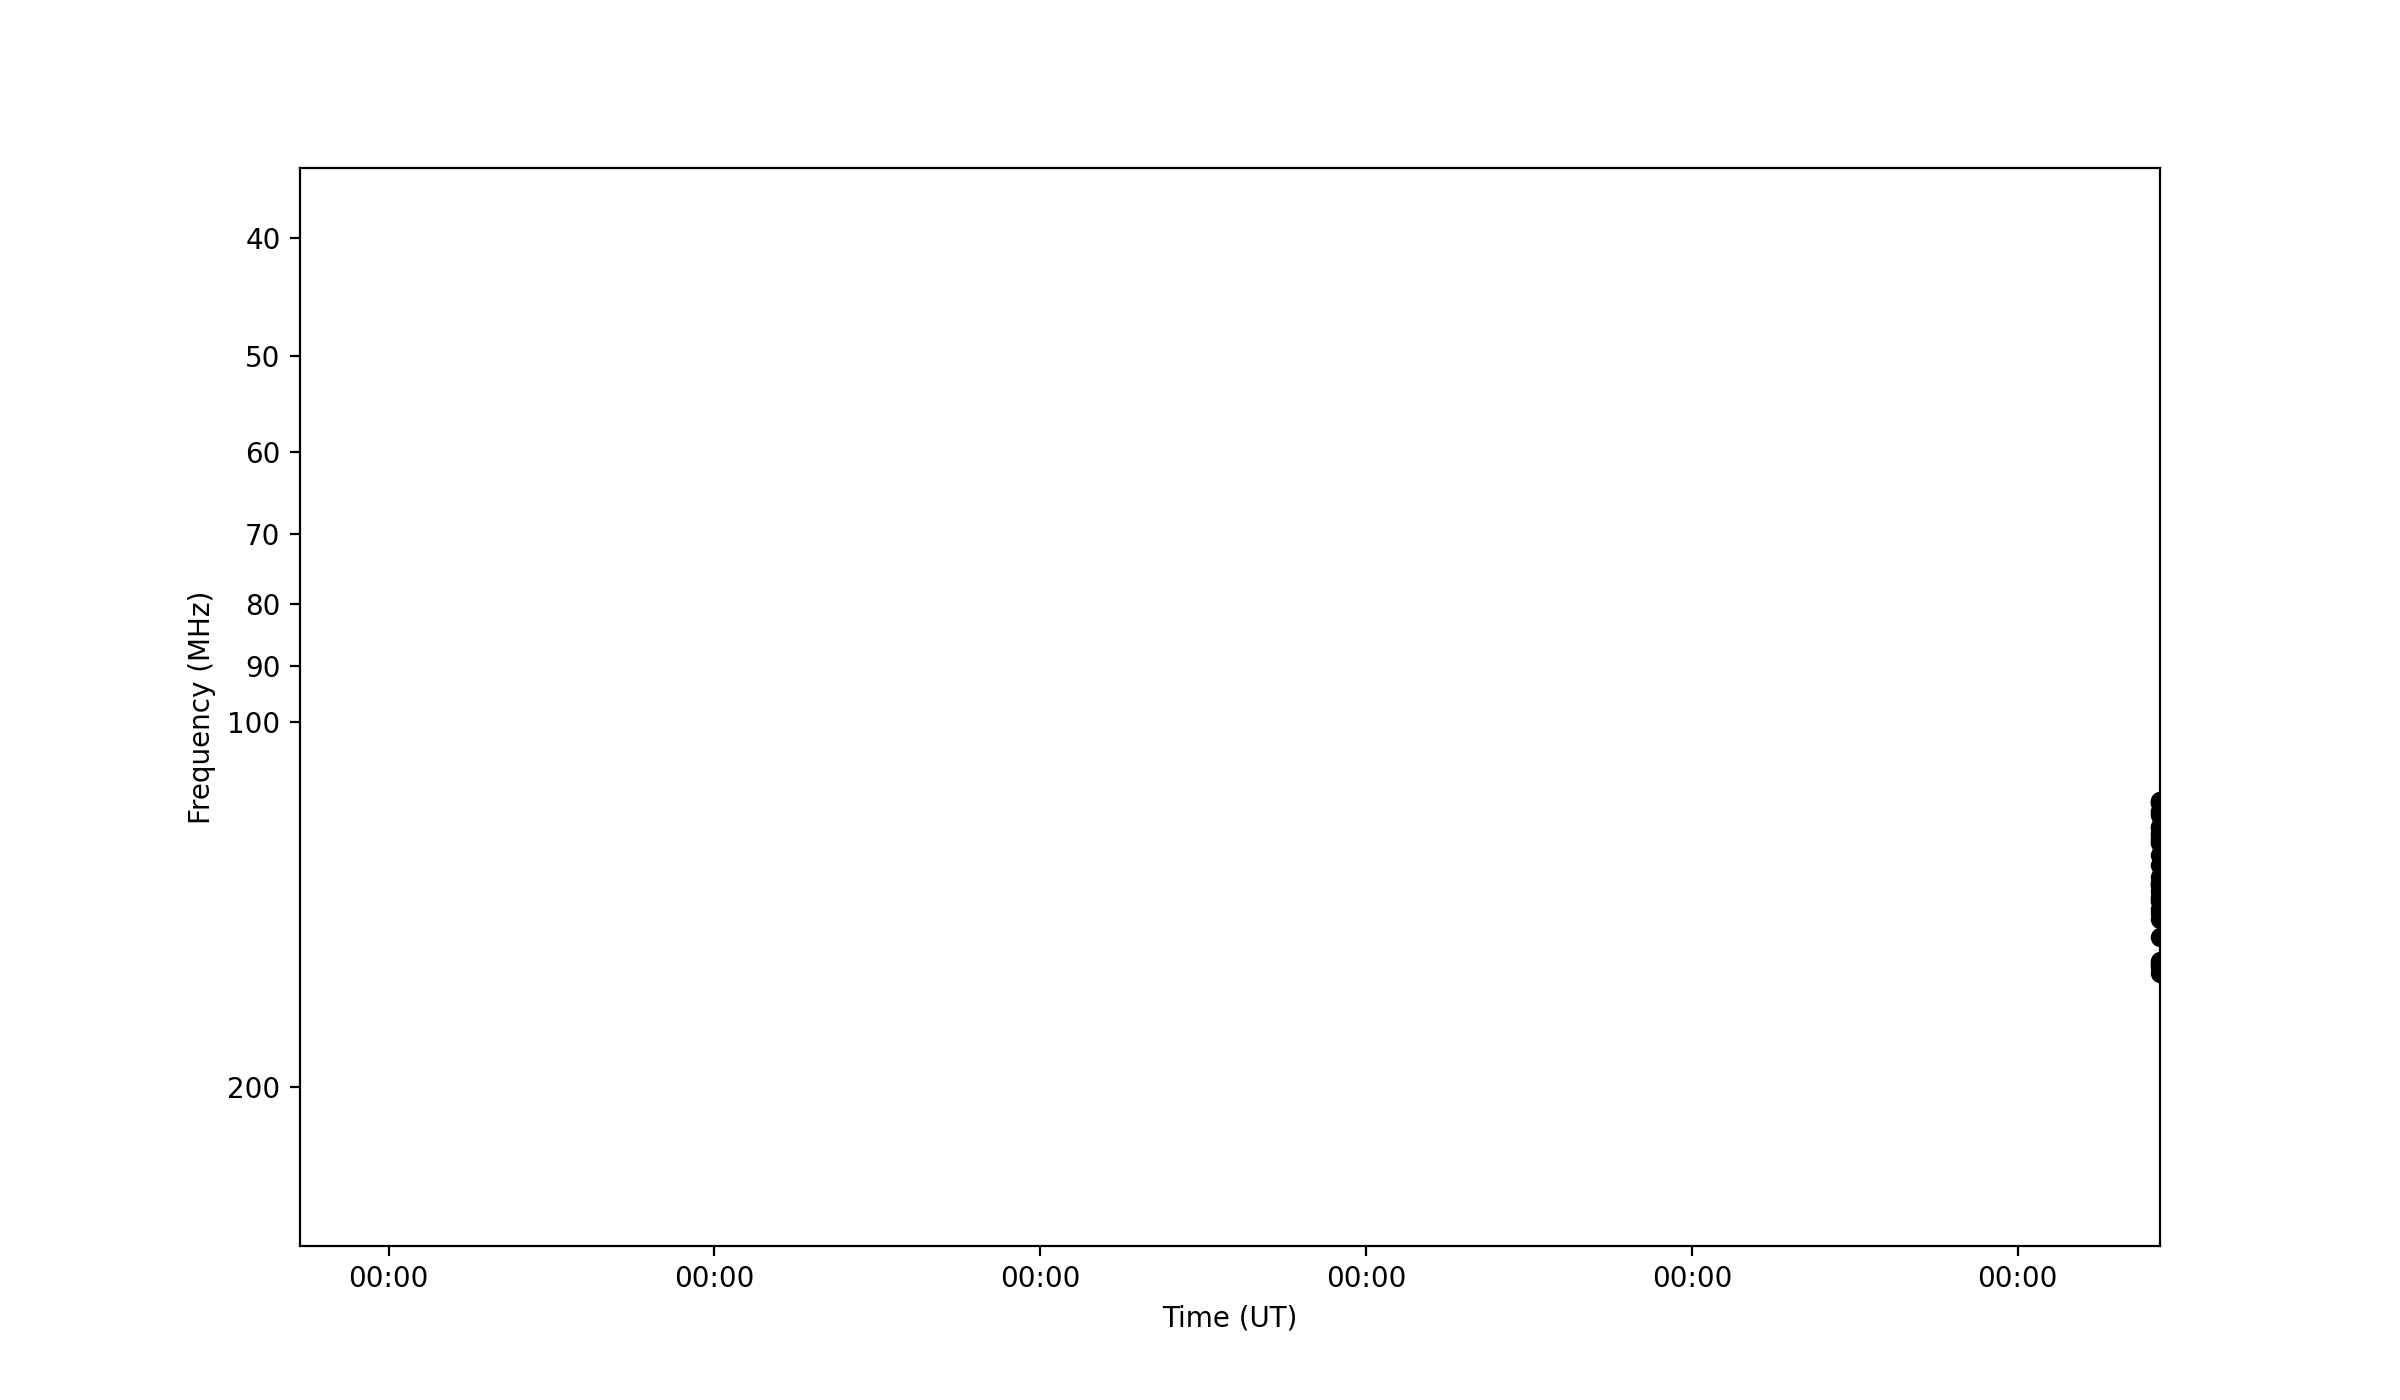

In [22]:
min_range = -0.5
max_range = 3

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
ax.pcolormesh(typeII_1_mode3_1s.index, typeII_1_mode3_1s.columns, typeII_1_mode3_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_1_mode5_1s.index, typeII_1_mode5_1s.columns, typeII_1_mode5_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_1_mode7_1s.index, typeII_1_mode7_1s.columns, typeII_1_mode7_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(max(ax.get_ylim()[::-1]), 35)

# List to store coordinates
typeII_1_f_t_points = []

# Function to be called when a mouse button is pressed
def onclick(event):
    if event.inaxes == ax:
        if event.button == 1:  # Left mouse button
            # Get the x and y coordinates
            x, y = event.xdata, event.ydata
            typeII_1_f_t_points.append((x, y))
            ax.plot(x, y, 'ko')  # Mark the point with a dot
            fig.canvas.draw()
        elif event.button == 3:  # Right mouse button
            # Disconnect the click event and exit the canvas
            fig.canvas.mpl_disconnect(cid)

# Connect the click event to the onclick function
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [24]:
df_typeII_1_f_t = pd.DataFrame(typeII_1_f_t_points, columns=['time','frequency'])
df_typeII_1_f_t.head()

time   frequency
0  19857.729661  161.210993
1  19857.729721  158.182548
2  19857.729777  159.387038
3  19857.729826  158.783651
4  19857.729878  157.583720

In [45]:
def freq_to_n(fpe):
    """
    Calculate electron density [cm-3] from plasma frequency [Hz].
    """
    ne = (fpe / (8.89*10**3))**2
    return ne


def newkirk_h(r):
    """
    Newkirk electron-density model.
    fold: is a multiplicative factor to change the density scaling.
    """
    fold = 2.5
    model = fold*4.2e4*10**(4.32/r)
    return model


def invert_newkirk_h(ne):
    """
    Invert the Newkirk electron-density model to find the radial distance
    for a given electron density.
    """
    def equation(r):
        # Define the equation for which we need to find the root.
        # It returns the difference between the model's density and the given density.
        return newkirk_h(r) - ne
    
    # Initial guess for the radial distance can be set to a reasonable value.
    r_guess = 1.0
    
    # Use fsolve to find the root of the equation, which is the radial distance r
    # that makes the equation zero.
    r_solution, = fsolve(equation, r_guess)
    return r_solution

In [46]:
# Convert frequencies to electron densities
ne_typeII_1 = freq_to_n(df_typeII_1_f_t['frequency'].values*10**6)

In [47]:
ne_typeII_1

array([3.28840865e+08, 3.16601968e+08, 3.21441895e+08, 3.19012753e+08,
       3.14209402e+08, 2.86870550e+08, 2.67939078e+08, 2.57966842e+08,
       2.61910407e+08, 2.50256952e+08, 2.48365756e+08, 2.46488852e+08,
       2.33741724e+08, 2.35521564e+08, 2.40942814e+08, 2.35521564e+08,
       2.28482499e+08, 2.18316386e+08, 2.10191023e+08, 1.99321030e+08,
       1.89013178e+08, 1.89013178e+08, 1.94836276e+08, 1.97814758e+08,
       2.00838772e+08, 1.93363896e+08, 1.80603216e+08, 1.71263352e+08,
       1.71263352e+08, 1.72567447e+08, 1.77883887e+08, 1.79238394e+08])

In [50]:
# Convert electron densities to radial distances
r_typeII_1 = [invert_newkirk_h(ne) for ne in ne_typeII_1]

<IPython.core.display.Javascript object>


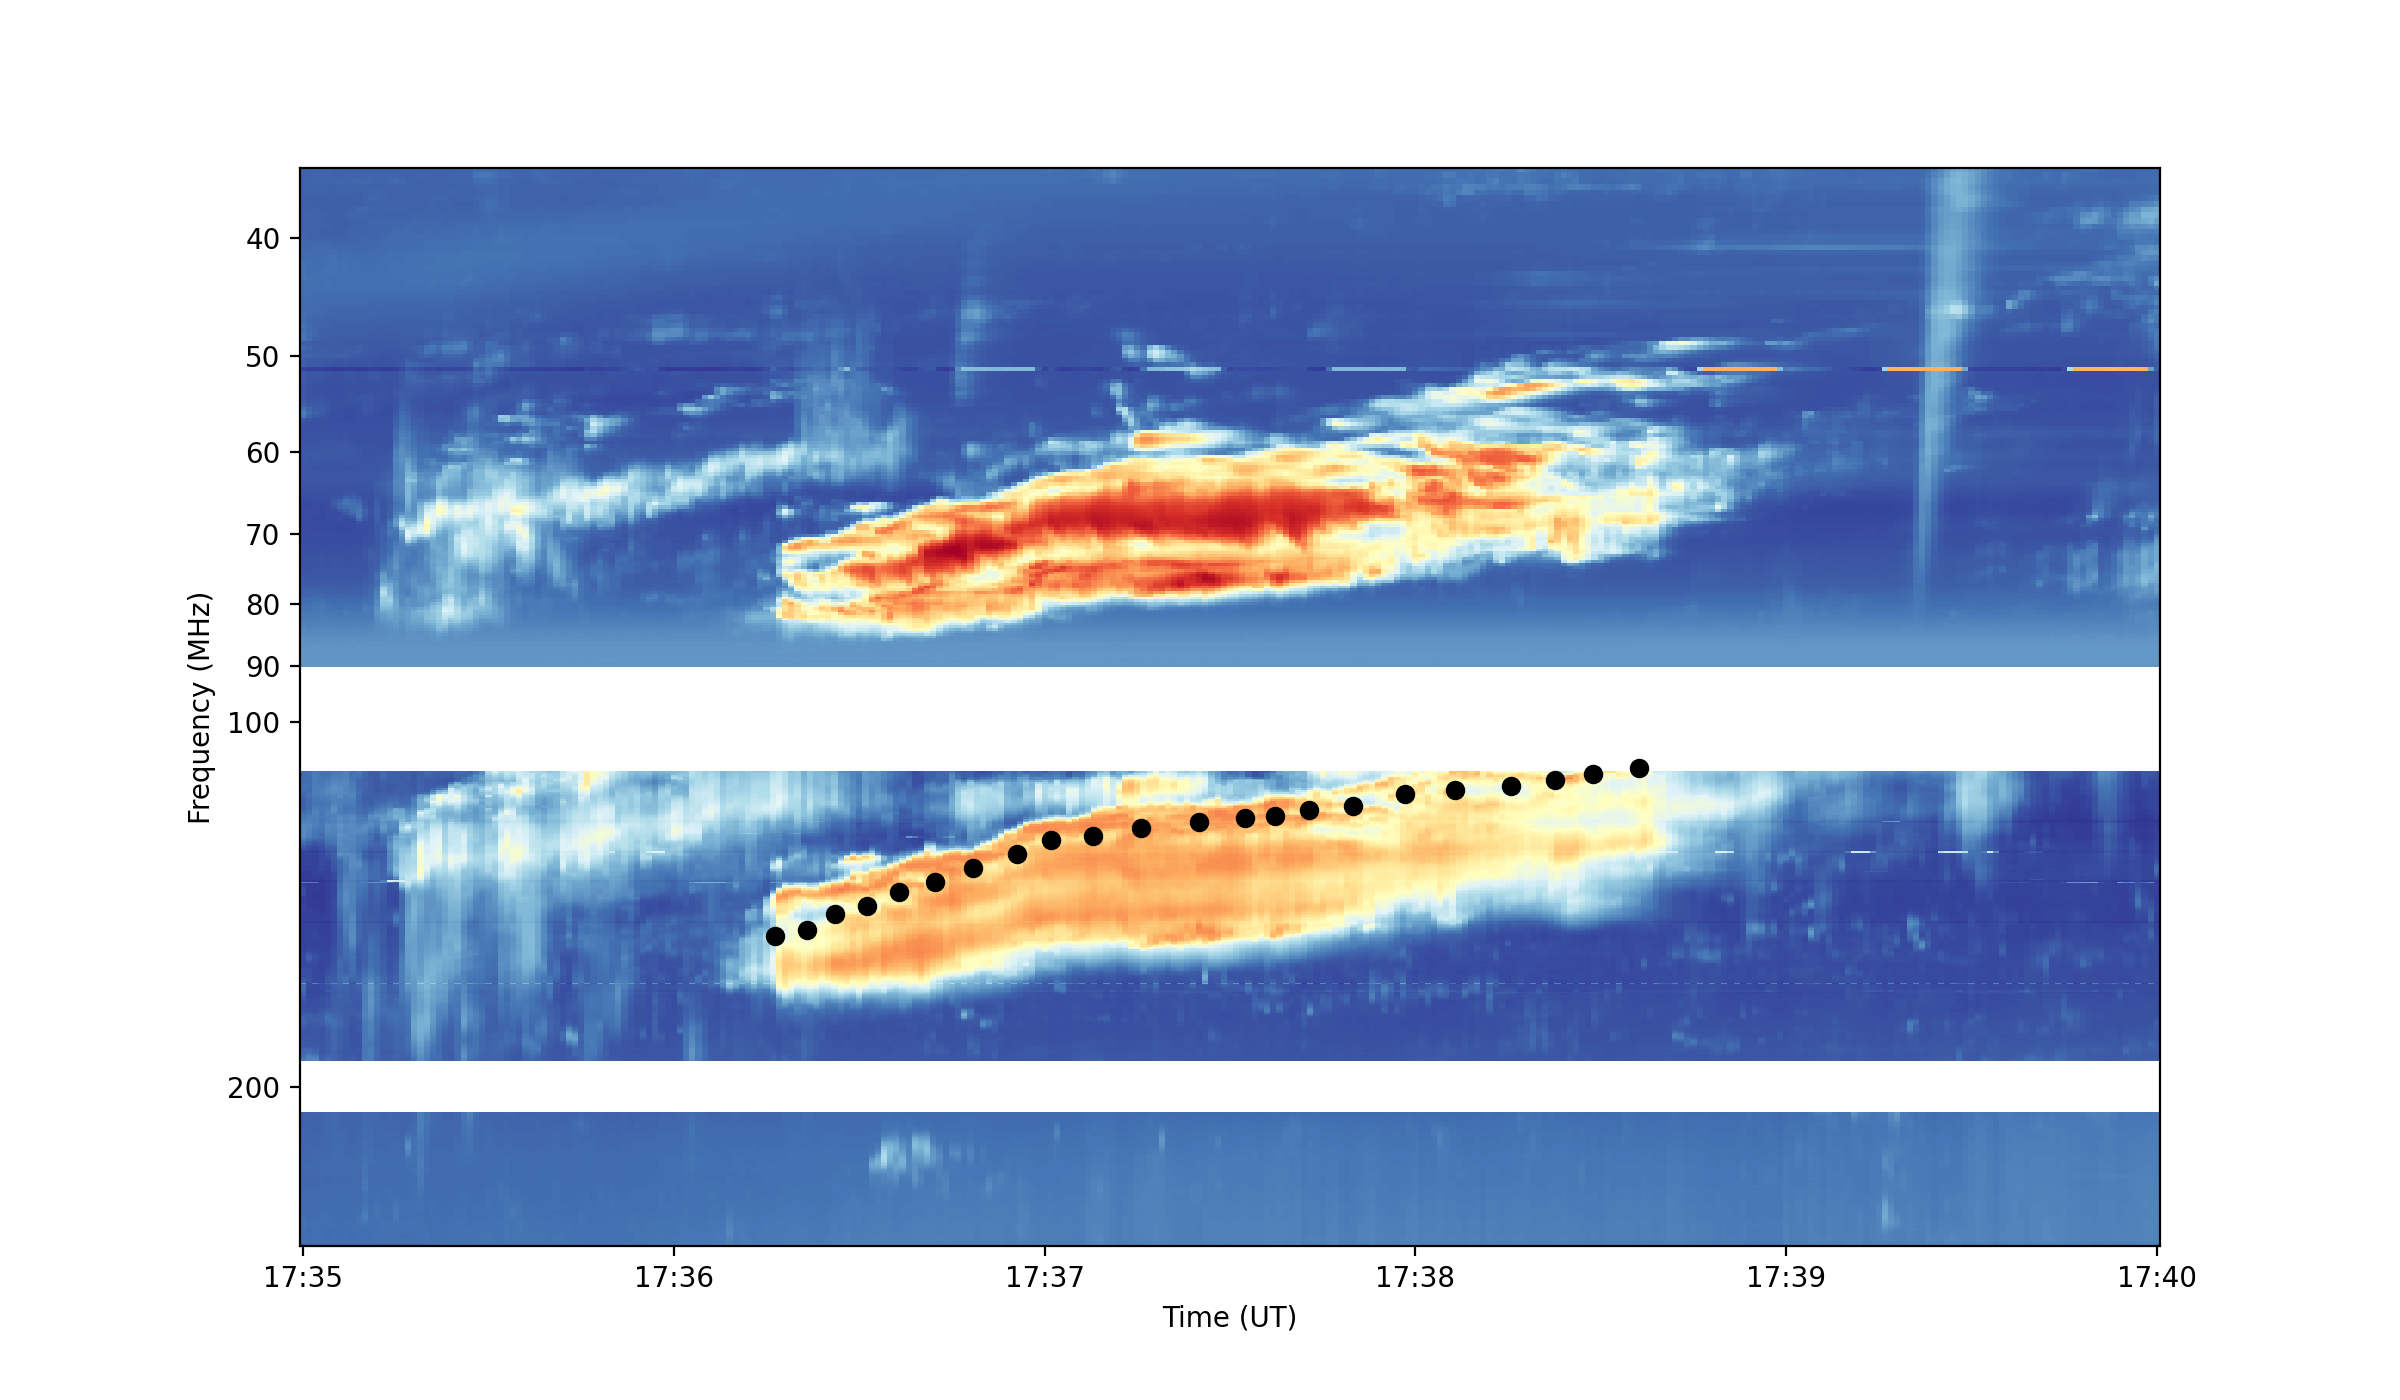

In [52]:
min_range = -0.5
max_range = 3

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
ax.pcolormesh(typeII_2_mode3_1s.index, typeII_2_mode3_1s.columns, typeII_2_mode3_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_2_mode5_1s.index, typeII_2_mode5_1s.columns, typeII_2_mode5_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_2_mode7_1s.index, typeII_2_mode7_1s.columns, typeII_2_mode7_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(190, 45)

# List to store coordinates
typeII_2_f_t_points = []

# Function to be called when a mouse button is pressed
def onclick(event):
    if event.inaxes == ax:
        if event.button == 1:  # Left mouse button
            # Get the x and y coordinates
            x, y = event.xdata, event.ydata
            typeII_2_f_t_points.append((x, y))
            ax.plot(x, y, 'ko')  # Mark the point with a dot
            fig.canvas.draw()
        elif event.button == 3:  # Right mouse button
            # Disconnect the click event and exit the canvas
            fig.canvas.mpl_disconnect(cid)

# Connect the click event to the onclick function
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [54]:
df_typeII_2_f_t = pd.DataFrame(typeII_2_f_t_points, columns=['time','frequency'])
df_typeII_2_f_t.head()

time   frequency
0  19857.733523  150.171163
1  19857.733583  148.472114
2  19857.733635  144.034708
3  19857.733695  141.865988
4  19857.733755  138.149007

In [55]:
# Convert frequencies to electron densities
ne_typeII_2 = freq_to_n(df_typeII_2_f_t['frequency'].values*10**6)

# Convert electron densities to radial distances
r_typeII_2 = [invert_newkirk_h(ne) for ne in ne_typeII_2]

<IPython.core.display.Javascript object>


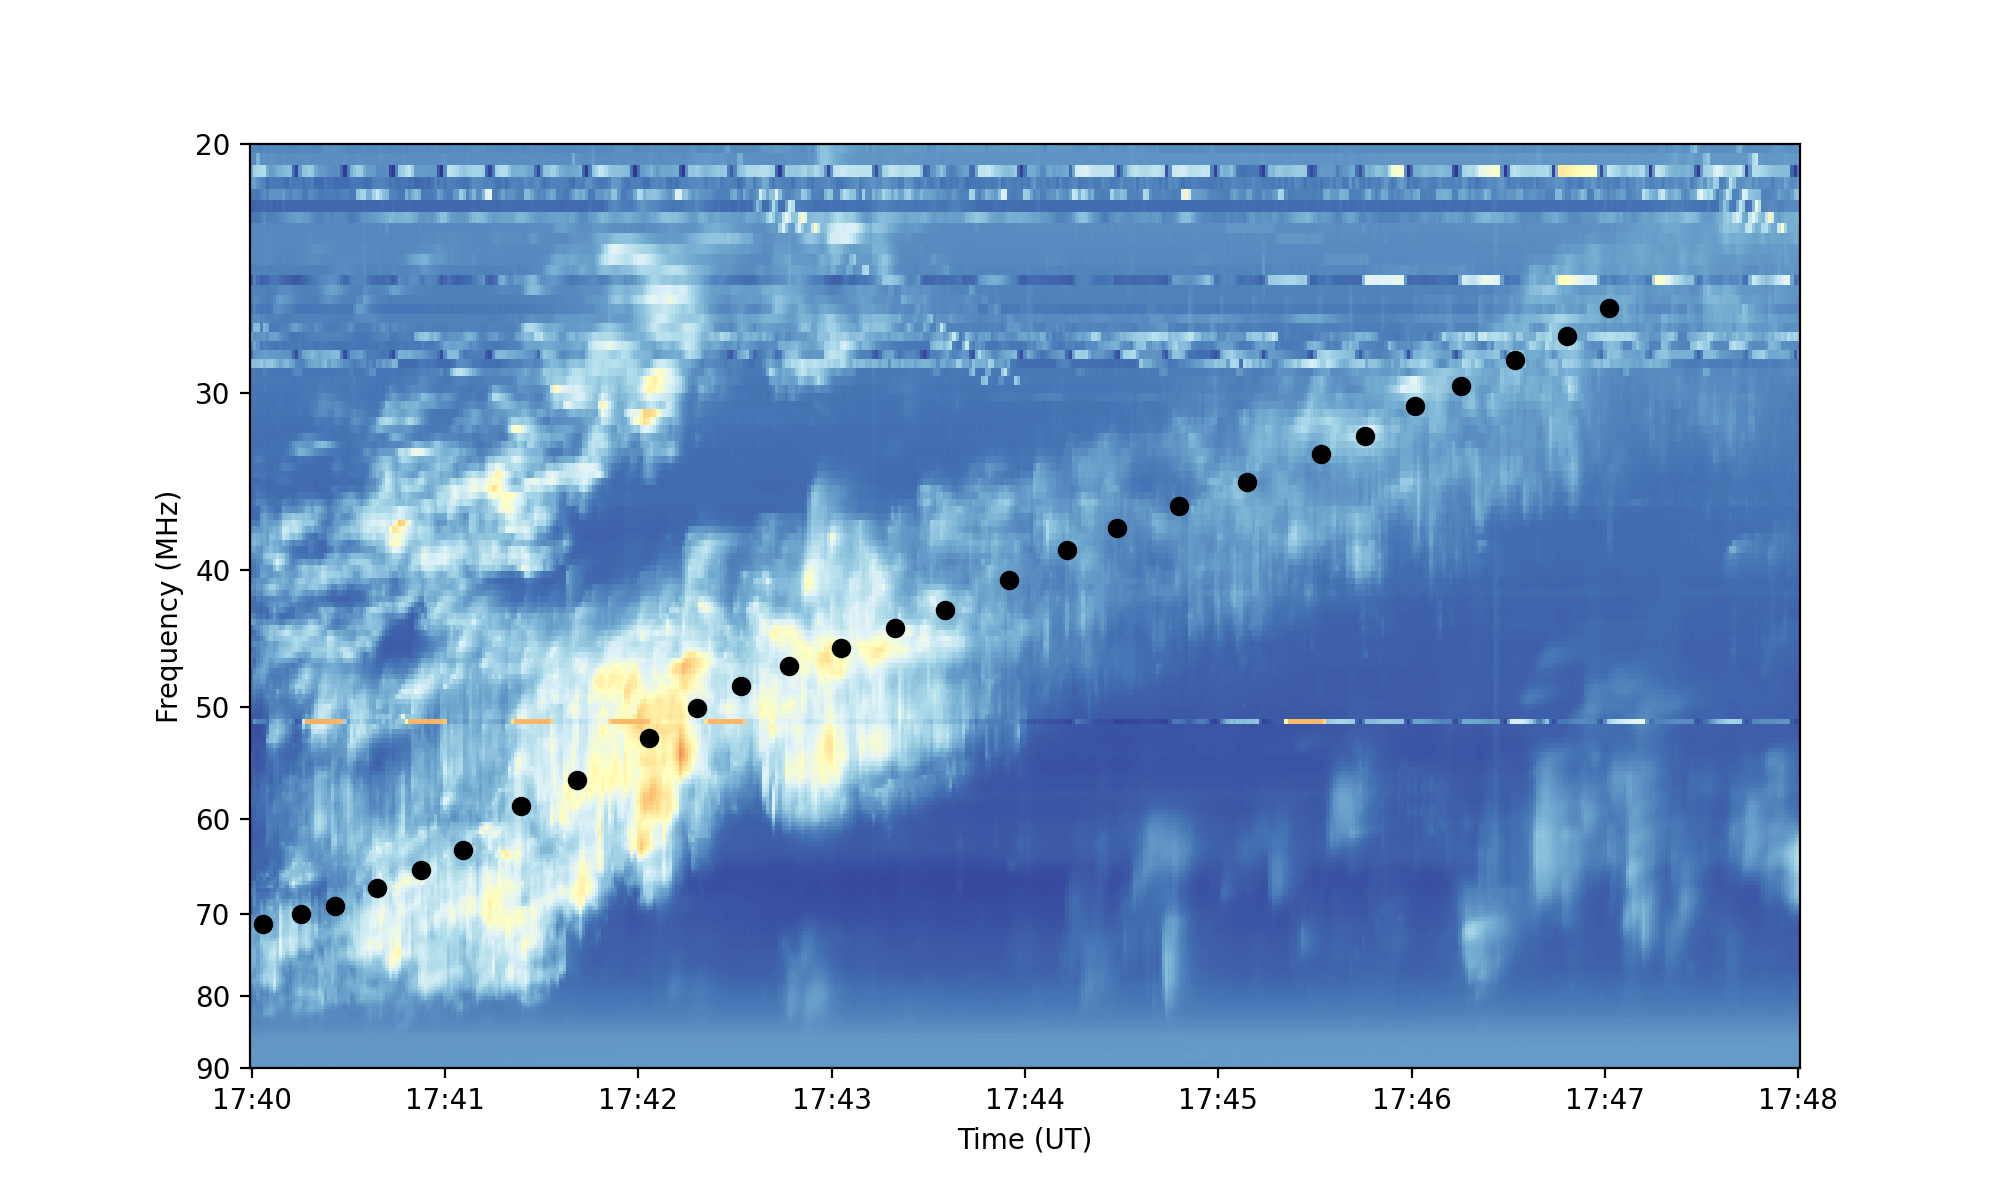

In [58]:
min_range = -0.5
max_range = 3

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
ax.pcolormesh(typeII_3_mode3_1s.index, typeII_3_mode3_1s.columns, typeII_3_mode3_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_3_mode5_1s.index, typeII_3_mode5_1s.columns, typeII_3_mode5_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.pcolormesh(typeII_3_mode7_1s.index, typeII_3_mode7_1s.columns, typeII_3_mode7_1s.values.T,
              vmin=min_range, vmax=max_range, cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.yaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(90, 20)

# List to store coordinates
typeII_3_f_t_points = []

# Function to be called when a mouse button is pressed
def onclick(event):
    if event.inaxes == ax:
        if event.button == 1:  # Left mouse button
            # Get the x and y coordinates
            x, y = event.xdata, event.ydata
            typeII_3_f_t_points.append((x, y))
            ax.plot(x, y, 'ko')  # Mark the point with a dot
            fig.canvas.draw()
        elif event.button == 3:  # Right mouse button
            # Disconnect the click event and exit the canvas
            fig.canvas.mpl_disconnect(cid)

# Connect the click event to the onclick function
cid = fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [59]:
df_typeII_3_f_t = pd.DataFrame(typeII_3_f_t_points, columns=['time','frequency'])
df_typeII_3_f_t.head()

time  frequency
0  19857.736152  71.246493
1  19857.736289  70.096138
2  19857.736411  69.189242
3  19857.736562  67.191394
4  19857.736720  65.251234

In [61]:
# Convert frequencies to electron densities
ne_typeII_3 = freq_to_n(df_typeII_3_f_t['frequency'].values*10**6)

# Convert electron densities to radial distances
r_typeII_3 = [invert_newkirk_h(ne) for ne in ne_typeII_3]

In [78]:
# Ensure all arrays are converted to lists
data = {
    'time_typeII_1': df_typeII_1_f_t['time'].tolist(),
    'freq_typeII_1': df_typeII_1_f_t['frequency'].tolist(),
    'ne_typeII_1': list(ne_typeII_1),
    'r_typeII_1': list(r_typeII_1),
    
    'time_typeII_2': df_typeII_2_f_t['time'].tolist(),
    'freq_typeII_2': df_typeII_2_f_t['frequency'].tolist(),
    'ne_typeII_2': list(ne_typeII_2),
    'r_typeII_2': list(r_typeII_2),
    
    'time_typeII_3': df_typeII_3_f_t['time'].tolist(),
    'freq_typeII_3': df_typeII_3_f_t['frequency'].tolist(),
    'ne_typeII_3': list(ne_typeII_3),
    'r_typeII_3': list(r_typeII_3)
}

# Find the maximum length
max_len = max(len(lst) for lst in data.values())

# Extend each list with None to the maximum length
for key in data:
    data[key] += [None] * (max_len - len(data[key]))

# Create the DataFrame and save it to a CSV file
df_data = pd.DataFrame(data)
df_data.to_csv('./newkirk_typeIIs.csv', index=False)

In [81]:
df_data.head()

time_typeII_1  freq_typeII_1   ne_typeII_1  r_typeII_1  time_typeII_2  \
0   19857.729661     161.210993  3.288409e+08    1.235770   19857.733523   
1   19857.729721     158.182548  3.166020e+08    1.241620   19857.733583   
2   19857.729777     159.387038  3.214419e+08    1.239274   19857.733635   
3   19857.729826     158.783651  3.190128e+08    1.240446   19857.733695   
4   19857.729878     157.583720  3.142094e+08    1.242797   19857.733755   

   freq_typeII_2   ne_typeII_2  r_typeII_2  time_typeII_3  freq_typeII_3  \
0     150.171163  2.853445e+08    1.257942   19857.736152      71.246493   
1     148.472114  2.789242e+08    1.261573   19857.736289      70.096138   
2     144.034708  2.625009e+08    1.271358   19857.736411      69.189242   
3     141.865988  2.546555e+08    1.276308   19857.736562      67.191394   
4     138.149007  2.414860e+08    1.285063   19857.736720      65.251234   

    ne_typeII_3  r_typeII_3  
0  6.422786e+07    1.550313  
1  6.217054e+07    1.558219  
2  6.057224e+07    1.564603  
3  5.712468e+07    1.579158  
4  5.387334e+07    1.593987

In [722]:
list(curves_dict.keys())

['time_h_lfb1',
 'freq_h_lfb1',
 'flux_h_lfb1',
 'time_h_lfb2',
 'freq_h_lfb2',
 'flux_h_lfb2',
 'time_h_lfb3',
 'freq_h_lfb3',
 'flux_h_lfb3',
 'time_h_ufb1',
 'freq_h_ufb1',
 'flux_h_ufb1',
 'time_h_ufb2',
 'freq_h_ufb2',
 'flux_h_ufb2',
 'time_h_ufb3',
 'freq_h_ufb3',
 'flux_h_ufb3',
 'time_f_lfb3',
 'freq_f_lfb3',
 'flux_f_lfb3',
 'time_f_ufb3',
 'freq_f_ufb3',
 'flux_f_ufb3']

In [788]:
newkirk_radial_distances = {}

In [793]:
Ne_U = []
rs_U = []
vr_U = []
dfdt_U = []

Ne_L = []
rs_L = []
vr_L = []
dfdt_L = []

# Enter Newkirk model fold number (1, 2, 3 or 4); 1 for quiet Sun, 4 for active regions
fold = 1

# Enter 1 for fundamental, 2 for harmonic
har = 2
lane = 3

if har == 1:
    band = 'f'
elif har == 2:
    band = 'h'

y_coords_U = curves_dict[f'freq_{band}_ufb{lane}']
x_coords_U = combined_typeII_df1_1s.index[curves_dict[f'time_{band}_ufb{lane}']] # extract the corresponding timestamps at those indices
timedelta_U = x_coords_U - x_coords_U[0] # get the time axis in seconds
time_in_seconds_U = np.array(timedelta_U.total_seconds())

y_coords_L = curves_dict[f'freq_{band}_lfb{lane}']
x_coords_L = combined_typeII_df1_1s.index[curves_dict[f'time_{band}_lfb{lane}']] # extract the corresponding timestamps at those indices
timedelta_L = x_coords_L - x_coords_L[0] # get the time axis in seconds
time_in_seconds_L = np.array(timedelta_L.total_seconds())



for i in range(0, len(y_coords_U)):
    ne_U = (y_coords_U[i] / (har * 8.977e-3))**2
    Ne_U.append(ne_U) # electron density
    
    r_newkirk_U = 4.32 / (np.log10(ne_U/(fold * 4.2e4)))
    rs_U.append(r_newkirk_U) # radial distance

    ne_L = (y_coords_L[i] / (har * 8.977e-3))**2
    Ne_L.append(ne_L) # electron density

    r_newkirk_L = 4.32 / (np.log10(ne_L/(fold * 4.2e4)))
    rs_L.append(r_newkirk_L) # radial distance

newkirk_radial_distances[f'rs_{fold}fold_{band}_ufb{lane}'] = rs_U
newkirk_radial_distances[f't_{fold}fold_{band}_ufb{lane}'] = x_coords_U

newkirk_radial_distances[f'rs_{fold}fold_{band}_lfb{lane}'] = rs_L
newkirk_radial_distances[f't_{fold}fold_{band}_lfb{lane}'] = x_coords_L

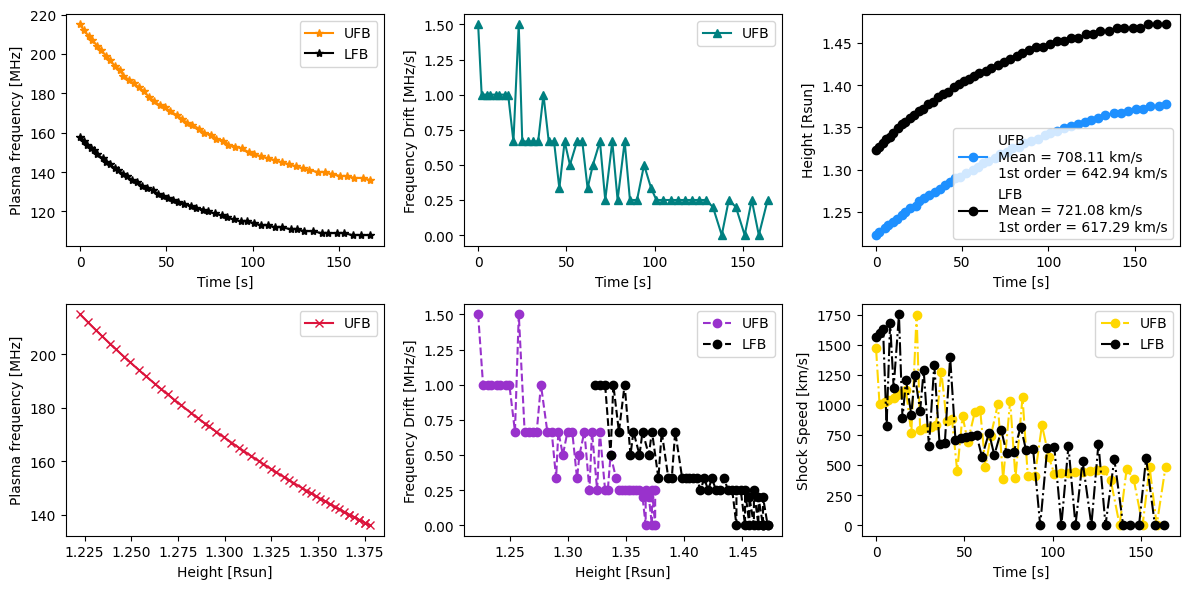

In [760]:
plt.figure(figsize=[12,6])

plt.subplot(2,3,1)
plt.plot(time_in_seconds_U, y_coords_U, '-*', color='darkorange', label='UFB')
plt.plot(time_in_seconds_L, y_coords_L, '-*', color='black', label='LFB')
plt.xlabel('Time [s]')
plt.ylabel('Plasma frequency [MHz]')
plt.legend(loc='upper right')

plt.subplot(2,3,2)
dfdt_U = np.abs(np.diff(y_coords_U)/np.diff(time_in_seconds_U))
dfdt_L = np.abs(np.diff(y_coords_L)/np.diff(time_in_seconds_L))
plt.plot(time_in_seconds_U[:-1], dfdt_U, '-^', color='teal', label='UFB')
# plt.plot(x_coords_L[:-1], dfdt_L, '-^', color='black', label='LFB')
plt.xlabel('Time [s]')
plt.ylabel('Frequency Drift [MHz/s]')
plt.legend(loc='upper right')

plt.subplot(2,3,4)
plt.plot(rs_U, y_coords_U, '-x', color='crimson', label='UFB')
# plt.plot(rs_L, y_coords_L, '-x', color='black', label='LFB')
plt.ylabel('Plasma frequency [MHz]')
plt.xlabel('Height [Rsun]')
plt.legend(loc='upper right')

plt.subplot(2,3,5)
plt.plot(rs_U[:-1], dfdt_U, '--o', color='darkorchid', label='UFB')
plt.plot(rs_L[:-1], dfdt_L, '--o', color='black', label='LFB')
plt.ylabel('Frequency Drift [MHz/s]')
plt.xlabel('Height [Rsun]')
plt.legend(loc='upper right')

plt.subplot(2,3,6)
vr_U = (np.diff(rs_U)*696340)/np.diff(time_in_seconds_U) # convert height from Rs to km
vr_L = (np.diff(rs_L)*696340)/np.diff(time_in_seconds_L)
plt.plot(time_in_seconds_U[:-1], vr_U, '-.o', color='gold', label='UFB')
plt.plot(time_in_seconds_L[:-1], vr_L, '-.o', color='black', label='LFB')
plt.xlabel('Time [s]')
plt.ylabel('Shock Speed [km/s]')
plt.legend(loc='upper right')

ym_U = np.nanmean(vr_U)
ym_L = np.nanmean(vr_L)
v1_U = ((rs_U[-1] - rs_U[0])*696340)/(time_in_seconds_U[-1] - time_in_seconds_U[0])
v1_L = ((rs_L[-1] - rs_L[0])*696340)/(time_in_seconds_L[-1] - time_in_seconds_L[0])
plt.subplot(2,3,3)
plt.plot(time_in_seconds_U, rs_U, '-o', color='dodgerblue', label=f'UFB\nMean = {ym_U:.2f} km/s\n1st order = {v1_U:.2f} km/s')
plt.plot(time_in_seconds_L, rs_L, '-o', color='black', label=f'LFB\nMean = {ym_L:.2f} km/s\n1st order = {v1_L:.2f} km/s')
plt.xlabel('Time [s]')
plt.ylabel('Height [Rsun]')
plt.legend()

plt.tight_layout()
plt.show()

In [777]:
df_aia171 = pd.read_csv('./jplot_aia_171_CME_No2.csv')
df_aia193 = pd.read_csv('./jplot_aia_193_CME_No2.csv')
df_aia211 = pd.read_csv('./jplot_aia_211_CME_No2.csv')

df_suvi171 = pd.read_csv('./jplot_suvi_171_CME_No2.csv')
df_suvi195 = pd.read_csv('./jplot_suvi_195_CME_No2.csv')
df_suvi284 = pd.read_csv('./jplot_suvi_284_CME_No2.csv')

In [779]:
def generate_centered_list(center, difference, num_elements):
    """
    Generate a list of numbers centered around a given number with a specified difference
    between consecutive numbers.

    Parameters:
    center (int): The central number around which the list is generated.
    difference (int): The difference between consecutive numbers in the list.
    num_elements (int): The number of elements before and after the central number.

    Returns:
    list: A list of numbers centered around the specified central number.
    """
    return [center + difference * i for i in range(-num_elements, num_elements + 1)]


centered_list = generate_centered_list(160, 2, 3)

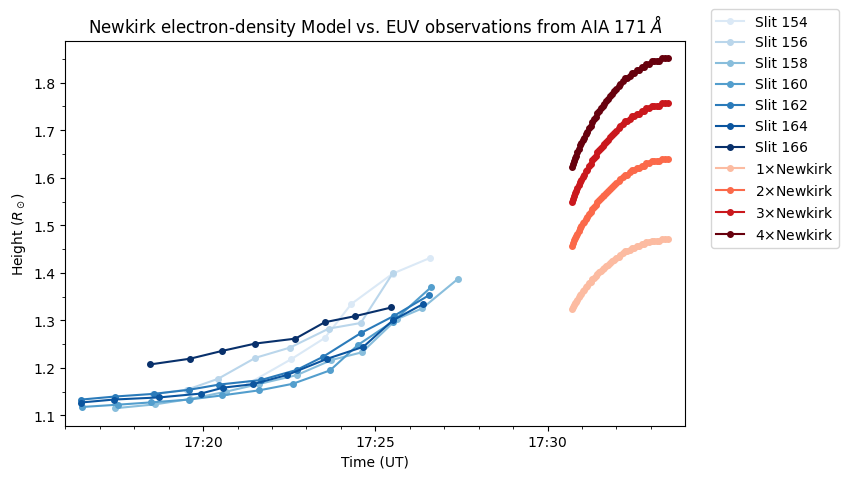

In [821]:
# Generate gradient colors
cmap_radio = plt.get_cmap('Reds')
cmap_cme = plt.get_cmap('Blues')

# make 3 evenly spaced colors from the colormaps
colors_radio = [cmap_radio(i / 4) for i in range(1, 5)]
colors171_cme = [cmap_cme(i / len(centered_list)) for i in range(1, len(centered_list)+1)]

rsun_aia = 949.556184 # solar radius in arcsec in AIA FOV
rsun_suvi = 949.1129337297962

fig = plt.figure(figsize=[8,5])
ax = fig.add_subplot(111)

for i, angle in enumerate(centered_list):
    ax.plot(df_aia171[f'x_{angle}deg'], df_aia171[f'y_{angle}deg']/rsun_aia, 'o-', ms=4, color=colors171_cme[i], label=f'Slit {angle}')

# cmap_radio_ccuddy = plt.get_cmap('Greens')
# colors_radio_ccuddy = [cmap_radio_ccuddy(i / 16) for i in range(1, 16)]
# for i in range(1,15):
#     df = pd.read_csv(f'./ccuddy/burst{i}.csv')
#     x_coords = df.columns.values.astype('float64')
#     y_coords = df.values.reshape(-1)
#     ax.plot(x_coords, y_coords, 'o-', ms=4, color=colors_radio_ccuddy[i], label=f'Type II no.{i}')

for i in range(1, 5):
    x_coords = newkirk_radial_distances[f't_{i}fold_{band}_{subband}fb{lane}']
    y_coords = newkirk_radial_distances[f'rs_{i}fold_{band}_{subband}fb{lane}']
    ax.plot(x_coords, y_coords, 'o-', ms=4, color=colors_radio[i-1], label=str(i)+r'$\times$Newkirk')

ax.legend(bbox_to_anchor=(1.03, 1.1))
ax.set_xlabel('Time (UT)')
ax.set_ylabel(r'Height ($R_\odot$)')
ax.set_title(r'Newkirk electron-density Model vs. EUV observations from AIA 171 $\AA$')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=2))
ax.set_xlim(left=pd.Timestamp('2024-05-14 17:16'), right=pd.Timestamp('2024-05-14 17:34'))
plt.show()

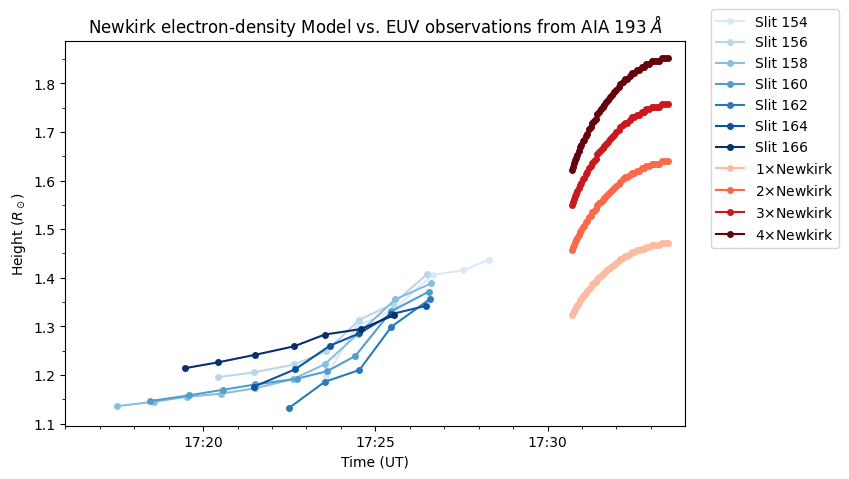

In [822]:
# Generate gradient colors
cmap_radio = plt.get_cmap('Reds')
cmap_cme = plt.get_cmap('Blues')

# make evenly spaced colors from the colormaps
colors_radio = [cmap_radio(i / 4) for i in range(1, 5)]
colors193_cme = [cmap_cme(i / len(centered_list)) for i in range(1, len(centered_list)+1)]

fig = plt.figure(figsize=[8,5])
ax = fig.add_subplot(111)

for i, angle in enumerate(centered_list):
    ax.plot(df_aia193[f'x_{angle}deg'], df_aia193[f'y_{angle}deg']/rsun_aia, 'o-', ms=4, color=colors193_cme[i], label=f'Slit {angle}')

for i in range(1, 5):
    x_coords = newkirk_radial_distances[f't_{i}fold_{band}_{subband}fb{lane}']
    y_coords = newkirk_radial_distances[f'rs_{i}fold_{band}_{subband}fb{lane}']
    ax.plot(x_coords, y_coords, 'o-', ms=4, color=colors_radio[i-1], label=str(i)+r'$\times$Newkirk')

ax.legend(bbox_to_anchor=(1.03, 1.1))
ax.set_xlabel('Time (UT)')
ax.set_ylabel(r'Height ($R_\odot$)')
ax.set_title(r'Newkirk electron-density Model vs. EUV observations from AIA 193 $\AA$')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=2))
ax.set_xlim(left=pd.Timestamp('2024-05-14 17:16'), right=pd.Timestamp('2024-05-14 17:34'))
plt.show()

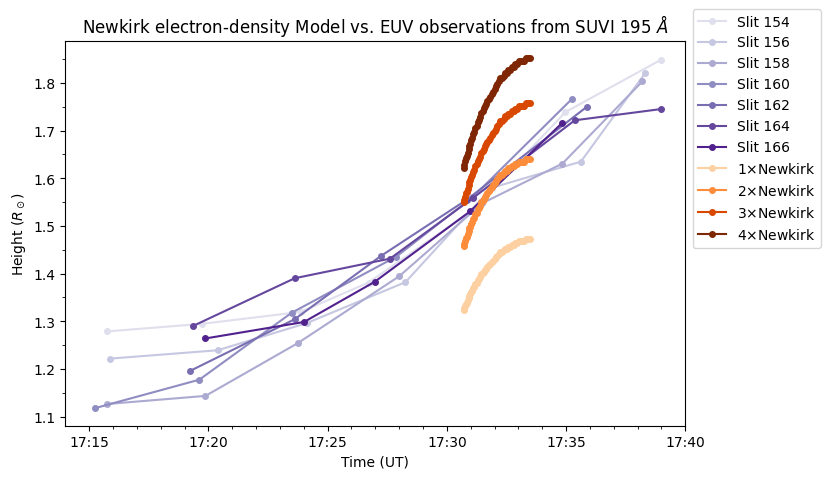

In [831]:
# Generate gradient colors
cmap_radio = plt.get_cmap('Oranges')
cmap_cme = plt.get_cmap('Purples')

# make evenly spaced colors from the colormaps
colors_radio = [cmap_radio(i / 4) for i in range(1, 5)]
color_offset = 2
colors195_cme = [cmap_cme(i / (len(centered_list)+color_offset)) for i in range(color_offset, len(centered_list)+color_offset)]

fig = plt.figure(figsize=[8,5])
ax = fig.add_subplot(111)

for i, angle in enumerate(centered_list):
    ax.plot(df_suvi195[f'x_{angle}deg'], df_suvi195[f'y_{angle}deg']/rsun_suvi, 'o-', ms=4, color=colors195_cme[i], label=f'Slit {angle}')

for i in range(1, 5):
    x_coords = newkirk_radial_distances[f't_{i}fold_{band}_{subband}fb{lane}']
    y_coords = newkirk_radial_distances[f'rs_{i}fold_{band}_{subband}fb{lane}']
    ax.plot(x_coords, y_coords, 'o-', ms=4, color=colors_radio[i-1], label=str(i)+r'$\times$Newkirk')

ax.legend(bbox_to_anchor=(1.23, 1.1))
ax.set_xlabel('Time (UT)')
ax.set_ylabel(r'Height ($R_\odot$)')
ax.set_title(r'Newkirk electron-density Model vs. EUV observations from SUVI 195 $\AA$')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=2))
ax.set_xlim(left=pd.Timestamp('2024-05-14 17:14'), right=pd.Timestamp('2024-05-14 17:40'))
plt.show()

In [794]:
list(newkirk_radial_distances.keys())

['rs_4fold_h_ufb3',
 't_4fold_h_ufb3',
 'rs_4fold_h_lfb3',
 't_4fold_h_lfb3',
 'rs_3fold_h_ufb3',
 't_3fold_h_ufb3',
 'rs_3fold_h_lfb3',
 't_3fold_h_lfb3',
 'rs_2fold_h_ufb3',
 't_2fold_h_ufb3',
 'rs_2fold_h_lfb3',
 't_2fold_h_lfb3',
 'rs_1fold_h_ufb3',
 't_1fold_h_ufb3',
 'rs_1fold_h_lfb3',
 't_1fold_h_lfb3']

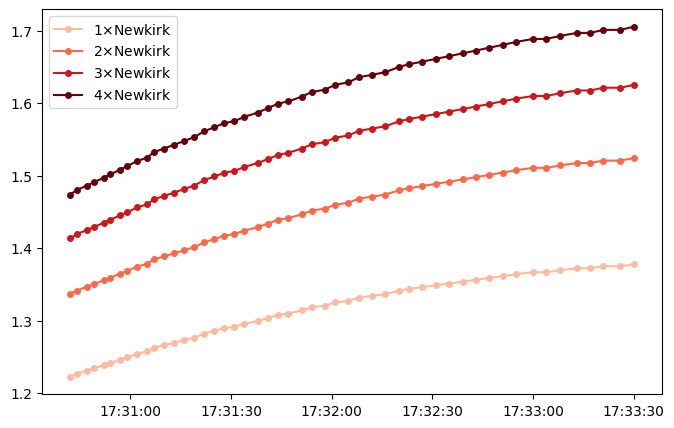

In [811]:
band = 'h'
subband = 'u'
lane = 3

cmap_radio = plt.get_cmap('Reds')
colors_radio = [cmap_radio(i / 4) for i in range(1, 5)]

fig = plt.figure(figsize=[8,5])
ax = fig.add_subplot(111)

for i in range(1, 5):
    x_coords = newkirk_radial_distances[f't_{i}fold_{band}_{subband}fb{lane}']
    y_coords = newkirk_radial_distances[f'rs_{i}fold_{band}_{subband}fb{lane}']
    ax.plot(x_coords, y_coords, 'o-', ms=4, color=colors_radio[i-1], label=str(i)+r'$\times$Newkirk')

ax.legend()
plt.show()

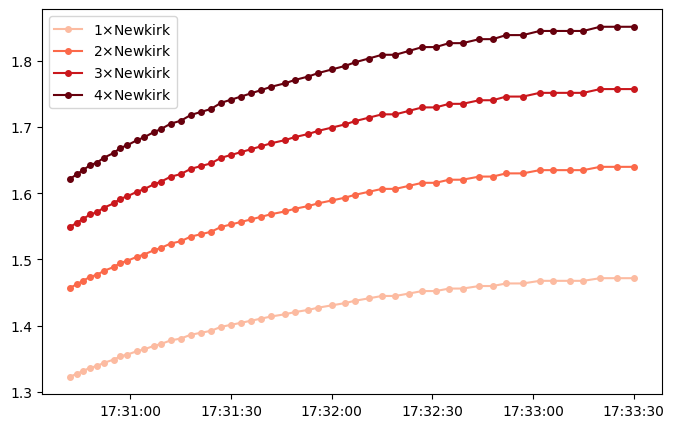

In [812]:
band = 'h'
subband = 'l'
lane = 3

cmap_radio = plt.get_cmap('Reds')
colors_radio = [cmap_radio(i / 4) for i in range(1, 5)]

fig = plt.figure(figsize=[8,5])
ax = fig.add_subplot(111)

for i in range(1, 5):
    x_coords = newkirk_radial_distances[f't_{i}fold_{band}_{subband}fb{lane}']
    y_coords = newkirk_radial_distances[f'rs_{i}fold_{band}_{subband}fb{lane}']
    ax.plot(x_coords, y_coords, 'o-', ms=4, color=colors_radio[i-1], label=str(i)+r'$\times$Newkirk')

ax.legend()
plt.show()